In [1]:
# imports
import sys
import time
from IPython.core.debugger import set_trace

import numpy as np
from numpy import linalg as LA
import math
import random

import matplotlib
#matplotlib.use('Agg')

import matplotlib.pyplot as plt

from itertools import count

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

import Intersection_finder_absoluteCoordinates_Module as I
import VertexObject as VO

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

Device: cuda


In [2]:
class DQN(nn.Module):
    """DQN class with h input nodes and output output nodes"""
    def __init__(self, h, outputs):
        super(DQN, self).__init__()
        self.fcn1 = nn.Linear(h,512)
        self.fcn2 = nn.Linear(512,256)
        self.fcn3 = nn.Linear(256,128)
        self.fcn4 = nn.Linear(128,64)
        #self.fcn6 = nn.Linear(64,10)
        self.fcn5 = nn.Linear(64,outputs)

    def forward(self, x):
        x = F.relu(self.fcn1(x))
        x = F.relu(self.fcn2(x))
        x = F.relu(self.fcn3(x))
        x = F.relu(self.fcn4(x))
        x = self.fcn5(x)
        return x


def select_action_DQN(state):
    """Selects an action either based on policy or randomly"""
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    a = 0
    if sample > eps_threshold:
        with torch.no_grad():
            # return the index of the max in output tensor
            state = state.to(device)
            a = (policy_net(state.flatten()).argsort())
    else:
        # return random bool
        a = np.random.choice(n_actions, n_actions,replace=False)
    #print("Action selected:", a)
    return [int(i) for i in a]

def init_weights(m):
    """Inits weights of m by random for linear layers"""
    if type(m) == nn.Linear:
        torch.nn.init.zeros_(m.weight)
        m.bias.data.fill_(0.00)

# maybe change reward such that it can be calculated after the experience
# this way training can be made faster by keeping experiences
# num steps is a bad thing as it is not         
def optimise_model_memory(batch_size):
    """
    This function performs one training step on policy net.
    
    State action value Q(s,a) is compared to r + Q_t(s',a')
    and a step of the optimiser is taken.
    """
    x_batch, y_batch = [], []
    action_batch = []
    batch_size = min(len(memory), batch_size)
    minibatch = random.sample(memory, batch_size)
    for state, action, reward, next_state, done in minibatch:
        x_batch.append(state.flatten())
        state = state.to(device)
        next_state = next_state.to(device)
        y_target = reward if done else reward + gamma * float((target_net(next_state.flatten()).max()).to('cpu'))
        action_batch.append(int(action))
        y_batch.append(y_target)
        #.type(torch.FloatTensor)
    with torch.no_grad():
        x_batch = torch.cat(x_batch).reshape((batch_size, n_inputs)).to(device)
        y_batch = torch.tensor(y_batch).type(torch.FloatTensor).squeeze().to(device)
        action_batch = torch.tensor(action_batch).reshape((batch_size,1)).to(device)
    optimizer.zero_grad()
    out = policy_net(x_batch).reshape((batch_size, n_actions))
    out = out.gather(1, action_batch).squeeze()
    loss = F.smooth_l1_loss(out, y_batch)
    #loss = F.mse_loss(out, y_batch)
    loss.backward()
    # clip error values to values between -1 and 1
    #for param in policy_net.parameters():
     #   param.grad.data.clamp_(-1, 1)
    optimizer.step()

In [3]:
np_load_old = np.load

# modify the default parameters of np.load
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)

# set up training as testing data

# load data in torch format
X_data = np.load('PFC_data_pocas_wrtJ.npy')
y_data = np.load('SV_true_pocas_wrtJ.npy')
print("Data loaded")
np.load = np_load_old


Data loaded


PFCatts = 'pt', 'eta', 'phi', 'charge', 'dxy', 'dz', 'pv_x', 'pv_y', 'pv_z',

            0     1     2        3          4    5    6         7       8 
            
           'theta', 'chi2', 'normalizedChi2','ndof', 'nPixelHits', 'deltaEta',
           
              9        10            11         12       13            14
              
           'deltaPhi', 'jetPtFrac', 
           
                15            16 
                
           'ptError', 'etaError', 'phiError',  'dxyError', 'dzError'
           
               17          18            19         20         21


In [17]:
num_pfc_cut = 8 # maxp
# do not use the most complicated parameters
X_data = X_data[:,:num_pfc_cut,:17] # do not include error for track params
print(f"Number of jets: {X_data.shape}")

# assign training and testing data
# randomize data
idx = np.random.choice(X_data.shape[0], X_data.shape[0],replace=False)
print(idx)
X_data = X_data[idx]
y_data = y_data[idx]

print(f"Number of jets: {X_data.shape}")
# split data to training, testing, validation data
X_train = X_data[:50000]
y_train = y_data[:50000]

X_test = X_data[50000:60000]
y_test = y_data[50000:60000]
if len(X_test) == 0:
    print("To much training data")

X_val = X_data[60000:]
y_val = y_data[60000:]
if len(X_val) == 0:
    print("To much testing data")


Number of jets: (70191, 8, 17)
[46976 50157 16081 ... 37422  8365 41504]
Number of jets: (70191, 8, 17)


Class definitions

In [19]:
#print(X_train.shape)
Env_test = VO.TrackEnvironment(X_train[0])
n_actions = 1 + 2 * Env_test.state.shape[0]
print(f"# actions: {n_actions}")

n_inputs = Env_test.state.shape[0] * Env_test.state.shape[1]
print(f"# inputs: {n_inputs}")


#for i in range(X_train[:50].shape[0]):
 #   print(X_train[i, :5, :14])


# actions: 17
# inputs: 80


In [6]:
memory = []

policy_net = DQN(n_inputs, n_actions).to(device)
target_net = DQN(n_inputs, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())
#target_net.load_state_dict(nn.init.zeros_(target_net.weight.size()))
optimizer = optim.Adam(policy_net.parameters(),lr=0.01)

print("NN initialised")

gamma = 0
GAMMA = 0.4 #0.9
EPS_START = 1
EPS_END = 0.1
EPS_DECAY = 10000
steps_done = 0

MINI_BATCH = 200
TARGET_UPDATE = 100

epochs = 1
num_episodes = 1000 #number of jets to train on
num_test_episodes = 500# number of jets to test on
max_episode_length = 25 #when to end a vertex attempt
run_test = True

NN initialised


In [7]:
'''
Env = VO.TrackEnvironment(X_train[12000])
y_true = y_train[12000,:3]
'''

'\nEnv = VO.TrackEnvironment(X_train[12000])\ny_true = y_train[12000,:3]\n'

In [8]:
'''
Env.take_action(2)
optimise_model_memory(MINI_BATCH)
x = Env.vertex.x
print(Env.state)
print(Env.vertex.track_indices)
print(LA.norm(x-y_true))
print(policy_net(Env.state.flatten().to(device)))
'''

'\nEnv.take_action(2)\noptimise_model_memory(MINI_BATCH)\nx = Env.vertex.x\nprint(Env.state)\nprint(Env.vertex.track_indices)\nprint(LA.norm(x-y_true))\nprint(policy_net(Env.state.flatten().to(device)))\n'

In [9]:
'''
plt.hist([memory[i][2] for i in range(len(memory))], bins=np.arange(-2500, 5, 100))
plt.show()
'''

'\nplt.hist([memory[i][2] for i in range(len(memory))], bins=np.arange(-2500, 5, 100))\nplt.show()\n'

In [10]:
'''
optimise_model_memory(MINI_BATCH)
print(policy_net(Env.state.flatten().to(device)))
'''

'\noptimise_model_memory(MINI_BATCH)\nprint(policy_net(Env.state.flatten().to(device)))\n'

In [11]:
            # clip rewards
            """
            if reward > -9:
                reward = 1
                if dflag:
                    reward += 1
            else:
                reward = -1
                if type(vertex_x) != np.ndarray:
                    reward -= 1
                if pflag:
                    reward -= 20
            """

'\nif reward > -9:\n    reward = 1\n    if dflag:\n        reward += 1\nelse:\n    reward = -1\n    if type(vertex_x) != np.ndarray:\n        reward -= 1\n    if pflag:\n        reward -= 20\n'

In [12]:
directory = '/beegfs/desy/user/rinckeph/work/Plots_training/1011/01/'
# loop over training data
steps_done = 0

episode_lengths = []
rewards = []

print("Start training")
start_time = time.time()

for i_epoch in range(epochs):
    # go through training data once per epoch
    episode_counter = 0
    train_ntracks_used = []
    train_vertex_error = []
    train_pflags = []
    train_steps = []
    for i in range(X_train.shape[0]):
        if X_train[i, 0, 0] == 0 or X_train[i, 1, 0] == 0:
            continue
        episode_counter += 1
        #print(f"Currentlyin  episode {episode_counter}")
        if episode_counter > num_episodes:
            print("Reached required number of episodes")
            break
        print(f"Currently at event: {i}" )
        Env = VO.TrackEnvironment(X_train[i])
        state = Env.state
        if len(memory) > 100000:
            print("Memory update")
            #l = len(memory)
            #idx = np.random.choice(l, l,replace=False)
            #memory = memory[idx]
            memory_r = random.sample(memory, len(memory))
            memory = memory_r[:50000]
            
        pflags_till_valid = -1
        steps_till_done = 0
        for t in count():
            print(f"Steps done: {steps_done}")
            true_SV = np.array([y_train[i,0], y_train[i,1], y_train[i,2]])
            #print(f"SV: {true_SV}")
            actions = select_action_DQN(state)
            next_state, vertex_x, uncertainty, n, pflag, dflag = -1, -1, -1, -1, True, False
            actions_index = 0
            action = 0
            while pflag:
                pflags_till_valid += 1
                action = actions[actions_index]
                if t > max_episode_length:
                    action = n_actions - 1
                    print("Episode will have ended forcefully")
                next_state, vertex_x, uncertainty, n, pflag, dflag = Env.take_action(action)
                actions_index += 1
            train_pflags.append(pflags_till_valid)
            steps_till_done += 1
            #print(Env.vertex.track_indices)
            #print(Env.state)
            # set up reward, if a vertex can be computed, set it to change in displacement
            reward = -10000 # if no vertex, this should be positive
            if type(vertex_x) == np.ndarray:
                reward = - np.sum((vertex_x-true_SV)**2)
                if dflag:
                    reward += 4
            if pflag:
                reward -= 10000

            rewards.append(reward)
            print(f"Reward for action {action}: {reward}")
            memory.append((state, action, reward, next_state, dflag))
            state = next_state
            #if i < 10:
             #   print(Env.state)
            print(Env.vertex.track_indices)
            optimise_model_memory(MINI_BATCH)
            optimise_model_memory(MINI_BATCH)
            #print("Did model update")
            if steps_done%TARGET_UPDATE == 0 and steps_done!= 0:
                target_net.load_state_dict(policy_net.state_dict())
                gamma = GAMMA
                print("Did target update")
            if dflag:
                print("Done flag")
                train_steps.append(steps_till_done)
                high_displacement = False
                if type(vertex_x) == np.ndarray:
                    if np.sum((vertex_x-true_SV)**2) > 36000:
                        high_displacement = True
                if i < 10 or high_displacement:
                    print("Trying to plot")
                    error_str = "no vertex"
                    if type(vertex_x) == np.ndarray:
                        error_str = f"{LA.norm(vertex_x-true_SV):.2f}"
                    uncer_str = "uncertainty"
                    if uncertainty != None:
                        uncer_str = f"{uncertainty:.4f}"
                    textstr = str(dflag)+f"\nreward: {reward} \nerror: {error_str} \nuncertainty: {uncer_str}"
                    fig, ax = I.helices_plot(Env.track_data,
                                 Env.vertex.track_indices, textstr=textstr, 
                                 pocas=Env.vertex.pocas, barrel=True,
                                 reco_vertex=vertex_x,true_vertex=true_SV)
                    fig.savefig(f"{directory}helix_train_{i}_ep_{i_epoch}.pdf")
                    plt.close()
                    print("Closed figure")
                if type(Env.vertex.x) == np.ndarray:
                    train_vertex_error.append(LA.norm(Env.vertex.x-true_SV))
                #print("Optional stuff done")
                train_ntracks_used.append(len(Env.vertex.track_indices))
                episode_lengths.append(t)
                if dflag:
                    print("Episode ended naturally")
                else:
                    print("Episode ended forcefully")
                #print("Break loop now")
                break
    plt.hist(train_ntracks_used, bins=range(n_actions//2))
    plt.xlabel("Num tracks used")
    plt.ylabel("Events")
    plt.title("Train sample")
    plt.savefig(f"{directory}RL_train_ntracks_epo{i_epoch}.pdf")
    plt.close()
        
    plt.hist(train_vertex_error)
    plt.xlabel("Vertexing error")
    plt.ylabel("Events")
    plt.title("Train sample")
    plt.yscale('log')
    plt.savefig(f"{directory}RL_train_displacement_epo{i_epoch}.pdf")
    plt.close()
    
    plt.hist(train_pflags, bins=range(n_actions//2))
    plt.xlabel("Number of attempts for valid action")
    plt.ylabel("Events")
    plt.title("Train sample")
    plt.savefig(f"{directory}RL_train_pflags_epo{i_epoch}.pdf")
    plt.close()
    
    plt.hist(train_steps, bins=range(max_episode_length))
    plt.xlabel("Number of steps before done")
    plt.ylabel("Events")
    plt.title("Train sample")
    plt.savefig(f"{directory}RL_train_nsteps_epo{i_epoch}.pdf")
    plt.close()   

    # test performance on test data once per episode (no random actions!)
    episode_counter = 0
    print("Should I do testing?")
    if not run_test:
        print("No :/")
        break
    print("Yes!")
    test_ntracks_used = []
    test_vertex_error = []
    test_decay_length = []
    test_pflags = []
    test_steps = []
    print("Started testing")
    for i in range(X_test.shape[0]):
        if episode_counter > num_test_episodes:
            print("Reached required number of test episodes")
            break
        episode_counter += 1
        Env = VO.TrackEnvironment(X_test[i])
        state = Env.state
        test_counter = 0
        n_pflags = -1
        n_steps = 0
        for t in count():
            steps_done += 1
            state = state.flatten().to(device)
            agent_out = policy_net(state)
            actions = policy_net(state).argsort()
            actions = [int(i) for i in actions]
            if t == 0 or action == n_actions-1:
                print(f"Predicted value of all actions: {agent_out}")    
            next_state, vertex_x, uncertainty, n, pflag, dflag = -1, -1, -1, -1, True, False
            actions_index = 0
            action = 0
            while pflag:
                n_pflags += 1
                action = actions[actions_index]
                if t > max_episode_length:
                    action = n_actions - 1
                    print("Episode will have ended forcefully")
                next_state, vertex_x, uncertainty, n, pflag, dflag = Env.take_action(action)
                actions_index += 1
            test_pflags.append(n_pflags)
            n_steps += 1
            true_SV = np.array([y_test[i,0], y_test[i,1], y_test[i,2]])
            test_decay_length.eppen(y_test[i,3])
            if dflag:
                print(f"It took {t+1} steps in testing")
                test_steps.append(n_steps)
                if i < 20:
                    error_str = "no vertex"
                    if type(vertex_x) == np.ndarray:
                        error_str = f"{LA.norm(vertex_x-true_SV):.2f}"
                    uncer_str = "uncertainty"
                    if uncertainty != None:
                        uncer_str = f"{uncertainty:.4f}"
                    textstr = f"\nerror: {error_str} \nuncertainty: {uncer_str}"
                    fig, ax = I.helices_plot(Env.track_data,
                                 Env.vertex.track_indices,
                                 textstr=textstr, 
                                 pocas=Env.vertex.pocas, barrel=True,
                                 reco_vertex=vertex_x,true_vertex=true_SV)

                    fig.savefig(f"{directory}helix_test_{i}_ep_{i_epoch}.pdf")
                    plt.close()

                if type(Env.vertex.x) == np.ndarray:
                    test_vertex_error.append(LA.norm(Env.vertex.x-true_SV))
                #else:
                    #test_vertex_error.append(1000000)
                test_ntracks_used.append(len(Env.vertex.track_indices))
                if dflag:
                    print("Episode ended naturally")
                else:
                    print("Episode ended forcefully")
                break

    plt.hist(test_ntracks_used, bins=range(n_actions//2))
    plt.xlabel("Num tracks used")
    plt.ylabel("Events")
    plt.title(f"Test sample, episode: {i_epoch}")
    plt.savefig(f"{directory}RL_test_ntracks_epo{i_epoch}.pdf")
    plt.close()
        
    plt.hist(test_vertex_error)
    plt.xlabel("Vertexing error")
    plt.ylabel("Events")
    plt.title(f"Test sample, episode: {i_epoch}")
    plt.yscale('log')
    plt.savefig(f"{directory}RL_test_error_epo{i_epoch}.pdf")
    plt.close()

    plt.hist(test_pflags, bins=range(n_actions//2))
    plt.xlabel("Number of attepts till valid action")
    plt.ylabel("Events")
    plt.title(f"Test sample, episode: {i_epoch}")
    plt.savefig(f"{directory}RL_test_npflags_epo{i_epoch}.pdf")
    plt.close()
                      
    plt.hist(test_steps, bins=range(max_episode_length))
    plt.xlabel("Number of steps till done")
    plt.ylabel("Events")
    plt.title(f"Test sample, episode: {i_epoch}")
    plt.savefig(f"{directory}RL_test_nsteps_epo{i_epoch}.pdf")
    plt.close()
    
    plt.scatter(test_decay_length, test_vertex_error)
    plt.xlabel("Decay length (cm)")
    plt.ylabel("Vertex error (cm)")
    plt.title(f"Test sample, epoch: {i_epoch}")
    plt.savefig(f"{directory}RL_test_decay_error_scatter_epo{i_epoch}.pdf")
    plt.close()

print(f"Training ended, it took {time.time()-start_time:.2f} seconds for {epochs} epochs with {num_episodes} jets totalling {steps_done} steps")


Start training
Currently at event: 0
Steps done: 0
SV: [ 0.04980092 -0.1992443   0.93090886]
Reward for action 4: -128.947696593653
[0, 1, 4]
Steps done: 1
SV: [ 0.04980092 -0.1992443   0.93090886]
Reward for action 20: -124.947696593653
[0, 1, 4]
Done flag
Trying to plot
Closed figure
Episode ended naturally
Currently at event: 1
Steps done: 2
SV: [ 1.0124997  0.745912  -4.073312 ]
Reward for action 20: -58.17350442404067
[0, 1]
Done flag
Trying to plot
Closed figure
Episode ended naturally
Currently at event: 2
Steps done: 3
SV: [-1.6873754   0.70178646 -0.39066747]
Reward for action 3: -107.22534390039922
[0, 1, 3]
Steps done: 4
SV: [-1.6873754   0.70178646 -0.39066747]
Reward for action 10: -285.5330813573991
[1, 3]
Steps done: 5
SV: [-1.6873754   0.70178646 -0.39066747]
Reward for action 2: -114.67580943403297
[1, 3, 2]
Steps done: 6
SV: [-1.6873754   0.70178646 -0.39066747]
Reward for action 0: -87.05162403596232
[1, 3, 2, 0]
Steps done: 7
SV: [-1.6873754   0.70178646 -0.39066747

Reward for action 0: -185.52662667890422
[1, 2, 0]
Steps done: 70
SV: [-1.4882338  -0.59926367  1.2225192 ]
Reward for action 20: -181.52662667890422
[1, 2, 0]
Done flag
Episode ended naturally
Currently at event: 11
Steps done: 71
SV: [ 0.09742707 -0.16998705 -0.7996769 ]
Reward for action 4: -36.55496555307452
[0, 1, 4]
Steps done: 72
SV: [ 0.09742707 -0.16998705 -0.7996769 ]
Reward for action 11: -54.72613227223304
[0, 4]
Steps done: 73
SV: [ 0.09742707 -0.16998705 -0.7996769 ]
Reward for action 1: -36.55496555307452
[0, 4, 1]
Steps done: 74
SV: [ 0.09742707 -0.16998705 -0.7996769 ]
Reward for action 11: -54.72613227223304
[0, 4]
Steps done: 75
SV: [ 0.09742707 -0.16998705 -0.7996769 ]
Reward for action 1: -36.55496555307452
[0, 4, 1]
Steps done: 76
SV: [ 0.09742707 -0.16998705 -0.7996769 ]
Reward for action 2: -35.23906011402096
[0, 4, 1, 2]
Steps done: 77
SV: [ 0.09742707 -0.16998705 -0.7996769 ]
Reward for action 14: -29.906642867228854
[0, 1, 2]
Steps done: 78
SV: [ 0.09742707 -

Reward for action 3: -4.201936371240027
[0, 1, 3]
Steps done: 141
SV: [ 0.0452977   0.00456714 -0.22409272]
Reward for action 11: -4.154110539568995
[0, 3]
Steps done: 142
SV: [ 0.0452977   0.00456714 -0.22409272]
Reward for action 8: -106.4958739583766
[0, 3, 8]
Steps done: 143
SV: [ 0.0452977   0.00456714 -0.22409272]
Reward for action 1: -53.967804083096986
[0, 3, 8, 1]
Steps done: 144
SV: [ 0.0452977   0.00456714 -0.22409272]
Reward for action 9: -1.1674643864907348
[0, 3, 8, 1, 9]
Steps done: 145
SV: [ 0.0452977   0.00456714 -0.22409272]
Reward for action 11: -0.49302413830094377
[0, 3, 8, 9]
Steps done: 146
SV: [ 0.0452977   0.00456714 -0.22409272]
Reward for action 20: 3.5069758616990563
[0, 3, 8, 9]
Done flag
Episode ended naturally
Currently at event: 18
Steps done: 147
SV: [-1.4376129 -1.2081318  9.19226  ]
Reward for action 2: -415.00157206936217
[0, 1, 2]
Steps done: 148
SV: [-1.4376129 -1.2081318  9.19226  ]
Reward for action 12: -422.01127828852134
[0, 1]
Steps done: 149


Steps done: 210
SV: [0.06548581 0.15702504 0.54994476]
Reward for action 2: -4.2137237849762315
[1, 5, 7, 6, 3, 2]
Steps done: 211
SV: [0.06548581 0.15702504 0.54994476]
Reward for action 20: -0.21372378497623146
[1, 5, 7, 6, 3, 2]
Done flag
Episode ended naturally
Currently at event: 26
Steps done: 212
SV: [ 1.3549623 -0.2696617  3.575531 ]
Reward for action 6: -53.063352978808915
[0, 1, 6]
Steps done: 213
SV: [ 1.3549623 -0.2696617  3.575531 ]
Reward for action 3: -117.4317010650505
[0, 1, 6, 3]
Steps done: 214
SV: [ 1.3549623 -0.2696617  3.575531 ]
Reward for action 4: -139.61446805401158
[0, 1, 6, 3, 4]
Steps done: 215
SV: [ 1.3549623 -0.2696617  3.575531 ]
Reward for action 11: -132.84081788505955
[0, 6, 3, 4]
Steps done: 216
SV: [ 1.3549623 -0.2696617  3.575531 ]
Reward for action 1: -139.6144680540117
[0, 6, 3, 4, 1]
Steps done: 217
SV: [ 1.3549623 -0.2696617  3.575531 ]
Reward for action 10: -111.81475178243245
[6, 3, 4, 1]
Steps done: 218
SV: [ 1.3549623 -0.2696617  3.575531 ]

Reward for action 5: -15.522282827734582
[0, 1, 5]
Steps done: 277
SV: [-0.05954222  0.04734319  0.1673675 ]
Reward for action 20: -11.522282827734582
[0, 1, 5]
Done flag
Episode ended naturally
Currently at event: 41
Steps done: 278
SV: [0.31600496 2.4327202  0.77756596]
Reward for action 2: -190.78896060549332
[0, 1, 2]
Steps done: 279
SV: [0.31600496 2.4327202  0.77756596]
Reward for action 20: -186.78896060549332
[0, 1, 2]
Done flag
Episode ended naturally
Currently at event: 42
Steps done: 280
SV: [-0.18031482 -0.11144966  0.24770133]
Reward for action 2: -1.2918152326276906
[0, 1, 2]
Steps done: 281
SV: [-0.18031482 -0.11144966  0.24770133]
Reward for action 7: -148.87527577511554
[0, 1, 2, 7]
Steps done: 282
SV: [-0.18031482 -0.11144966  0.24770133]
Reward for action 5: -126.73470008342073
[0, 1, 2, 7, 5]
Steps done: 283
SV: [-0.18031482 -0.11144966  0.24770133]
Reward for action 4: -58.04227083409765
[0, 1, 2, 7, 5, 4]
Steps done: 284
SV: [-0.18031482 -0.11144966  0.24770133]
R

Steps done: 345
SV: [-0.13411148 -0.29865724 -0.46986014]
Reward for action 19: -34.06563024233869
[0, 1]
Steps done: 346
SV: [-0.13411148 -0.29865724 -0.46986014]
Reward for action 5: -24.01539661881186
[0, 1, 5]
Steps done: 347
SV: [-0.13411148 -0.29865724 -0.46986014]
Reward for action 15: -34.06563024233869
[0, 1]
Steps done: 348
SV: [-0.13411148 -0.29865724 -0.46986014]
Reward for action 5: -24.01539661881186
[0, 1, 5]
Steps done: 349
SV: [-0.13411148 -0.29865724 -0.46986014]
Reward for action 2: -27.78243718822601
[0, 1, 5, 2]
Steps done: 350
SV: [-0.13411148 -0.29865724 -0.46986014]
Reward for action 3: -62.20450471568963
[0, 1, 5, 2, 3]
Steps done: 351
SV: [-0.13411148 -0.29865724 -0.46986014]
Reward for action 7: -43.84382057561984
[0, 1, 5, 2, 3, 7]
Steps done: 352
SV: [-0.13411148 -0.29865724 -0.46986014]
Reward for action 8: -32.66638920700455
[0, 1, 5, 2, 3, 7, 8]
Steps done: 353
SV: [-0.13411148 -0.29865724 -0.46986014]
Reward for action 20: -28.66638920700455
[0, 1, 5, 2

Steps done: 416
SV: [-0.12016743 -0.16848604  0.00447651]
Reward for action 20: 0.5763432372087411
[0, 1, 2]
Done flag
Episode ended naturally
Currently at event: 61
Steps done: 417
SV: [ 0.45306155 -0.160175    0.06680135]
Reward for action 2: -53.66213047880617
[0, 1, 2]
Steps done: 418
SV: [ 0.45306155 -0.160175    0.06680135]
Reward for action 5: -32.29562454654136
[0, 1, 2, 5]
Steps done: 419
SV: [ 0.45306155 -0.160175    0.06680135]
Reward for action 12: -9.980808283910404
[0, 1, 5]
Steps done: 420
SV: [ 0.45306155 -0.160175    0.06680135]
Reward for action 20: -5.980808283910404
[0, 1, 5]
Done flag
Episode ended naturally
Currently at event: 62
Steps done: 421
SV: [ 0.07466381 -0.0194338  -1.2529944 ]
Reward for action 3: -131.6882859878298
[0, 1, 3]
Steps done: 422
SV: [ 0.07466381 -0.0194338  -1.2529944 ]
Reward for action 6: -147.59043258573104
[0, 1, 3, 6]
Steps done: 423
SV: [ 0.07466381 -0.0194338  -1.2529944 ]
Reward for action 5: -128.96815474913527
[0, 1, 3, 6, 5]
Steps

Steps done: 484
SV: [-0.00427144  0.16435844  0.14448258]
Reward for action 1: -132.54813897818013
[3, 4, 1]
Steps done: 485
SV: [-0.00427144  0.16435844  0.14448258]
Reward for action 14: -5.629739756928034
[3, 1]
Steps done: 486
SV: [-0.00427144  0.16435844  0.14448258]
Reward for action 20: -1.6297397569280339
[3, 1]
Done flag
Episode ended naturally
Currently at event: 76
Steps done: 487
SV: [ 0.996339   -0.8748565   0.40717745]
Reward for action 20: -117.30089789659137
[0, 1]
Done flag
Episode ended naturally
Currently at event: 77
Steps done: 488
SV: [ 0.05056142 -0.06708403 -0.582641  ]
Reward for action 3: -27.86907973965023
[0, 1, 3]
Steps done: 489
SV: [ 0.05056142 -0.06708403 -0.582641  ]
Reward for action 4: -27.765947242389405
[0, 1, 3, 4]
Steps done: 490
SV: [ 0.05056142 -0.06708403 -0.582641  ]
Reward for action 13: -27.55149880781527
[0, 1, 4]
Steps done: 491
SV: [ 0.05056142 -0.06708403 -0.582641  ]
Reward for action 20: -23.55149880781527
[0, 1, 4]
Done flag
Episode e

Steps done: 552
SV: [ 0.04720749  0.10166313 -0.30000344]
Reward for action 20: 1.1474285077453064
[1, 8, 5, 0]
Done flag
Episode ended naturally
Currently at event: 92
Steps done: 553
SV: [-0.14364375  0.04694343 -0.14647768]
Reward for action 5: -6.362605591559899
[0, 1, 5]
Steps done: 554
SV: [-0.14364375  0.04694343 -0.14647768]
Reward for action 2: -4.83618667206656
[0, 1, 5, 2]
Steps done: 555
SV: [-0.14364375  0.04694343 -0.14647768]
Reward for action 11: -6.23083725727734
[0, 5, 2]
Steps done: 556
SV: [-0.14364375  0.04694343 -0.14647768]
Reward for action 10: -3.420785676338779
[5, 2]
Steps done: 557
SV: [-0.14364375  0.04694343 -0.14647768]
Reward for action 6: -2.415086928376833
[5, 2, 6]
Steps done: 558
SV: [-0.14364375  0.04694343 -0.14647768]
Reward for action 12: -1.2952280959388907
[5, 6]
Steps done: 559
SV: [-0.14364375  0.04694343 -0.14647768]
Reward for action 4: -2.024165883487742
[5, 6, 4]
Steps done: 560
SV: [-0.14364375  0.04694343 -0.14647768]
Reward for action 

Steps done: 621
SV: [ 0.57960165  0.1173381  -3.6108768 ]
Reward for action 20: -632.659189376709
[0, 1, 4, 6]
Done flag
Episode ended naturally
Currently at event: 97
Steps done: 622
SV: [ 0.03939867  0.21617189 -0.9468221 ]
Reward for action 20: -136.58678033460473
[0, 1]
Done flag
Episode ended naturally
Currently at event: 98
Steps done: 623
SV: [-0.7941267   0.67478174 -0.16195317]
Reward for action 3: -1.7034996181027064
[0, 1, 3]
Steps done: 624
SV: [-0.7941267   0.67478174 -0.16195317]
Reward for action 20: 2.2965003818972933
[0, 1, 3]
Done flag
Episode ended naturally
Currently at event: 99
Steps done: 625
SV: [ 0.26431623 -3.7746499   0.9201708 ]
Reward for action 20: -321.829605613621
[0, 1]
Done flag
Episode ended naturally
Currently at event: 100
Steps done: 626
SV: [ 0.5369703  -0.02785907 -2.5553014 ]
Reward for action 5: -626.0737050984136
[0, 1, 5]
Steps done: 627
SV: [ 0.5369703  -0.02785907 -2.5553014 ]
Reward for action 3: -271.4529641555883
[0, 1, 5, 3]
Steps done:

Reward for action 3: -134.22192039003014
[0, 1, 3]
Steps done: 687
SV: [ 0.10816506 -0.19704416  0.6891857 ]
Reward for action 4: -48.64799589528276
[0, 1, 3, 4]
Steps done: 688
SV: [ 0.10816506 -0.19704416  0.6891857 ]
Reward for action 2: -53.33782374077107
[0, 1, 3, 4, 2]
Steps done: 689
SV: [ 0.10816506 -0.19704416  0.6891857 ]
Reward for action 12: -48.64799589528276
[0, 1, 3, 4]
Steps done: 690
SV: [ 0.10816506 -0.19704416  0.6891857 ]
Reward for action 8: -51.676059222553924
[0, 1, 3, 4, 8]
Steps done: 691
SV: [ 0.10816506 -0.19704416  0.6891857 ]
Reward for action 14: -90.45050553629584
[0, 1, 3, 8]
Steps done: 692
SV: [ 0.10816506 -0.19704416  0.6891857 ]
Reward for action 2: -80.44363598612843
[0, 1, 3, 8, 2]
Steps done: 693
SV: [ 0.10816506 -0.19704416  0.6891857 ]
Reward for action 10: -93.53983429121587
[1, 3, 8, 2]
Steps done: 694
SV: [ 0.10816506 -0.19704416  0.6891857 ]
Reward for action 0: -80.44363598612848
[1, 3, 8, 2, 0]
Steps done: 695
SV: [ 0.10816506 -0.19704416 

Done flag
Episode ended naturally
Currently at event: 126
Steps done: 756
SV: [ 0.05220518 -0.01499177 -0.41688642]
Reward for action 5: -40.43703042761243
[0, 1, 5]
Steps done: 757
SV: [ 0.05220518 -0.01499177 -0.41688642]
Reward for action 15: -32.02202612891351
[0, 1]
Steps done: 758
SV: [ 0.05220518 -0.01499177 -0.41688642]
Reward for action 7: -29.032152335151775
[0, 1, 7]
Steps done: 759
SV: [ 0.05220518 -0.01499177 -0.41688642]
Reward for action 10: -6.386542513822719
[1, 7]
Steps done: 760
SV: [ 0.05220518 -0.01499177 -0.41688642]
Reward for action 8: -6.897637150476646
[1, 7, 8]
Steps done: 761
SV: [ 0.05220518 -0.01499177 -0.41688642]
Reward for action 5: -9.661929422708297
[1, 7, 8, 5]
Steps done: 762
SV: [ 0.05220518 -0.01499177 -0.41688642]
Reward for action 0: -29.45413811626287
[1, 7, 8, 5, 0]
Steps done: 763
SV: [ 0.05220518 -0.01499177 -0.41688642]
Reward for action 9: -154.08983968872155
[1, 7, 8, 5, 0, 9]
Steps done: 764
SV: [ 0.05220518 -0.01499177 -0.41688642]
Rewa

Steps done: 825
SV: [-0.23101519  0.25729334  0.38002282]
Reward for action 2: -35.30325144743469
[0, 1, 4, 2]
Steps done: 826
SV: [-0.23101519  0.25729334  0.38002282]
Reward for action 3: -20.84409125755204
[0, 1, 4, 2, 3]
Steps done: 827
SV: [-0.23101519  0.25729334  0.38002282]
Reward for action 6: -26.577106774325916
[0, 1, 4, 2, 3, 6]
Steps done: 828
SV: [-0.23101519  0.25729334  0.38002282]
Reward for action 13: -53.602144581417534
[0, 1, 4, 2, 6]
Steps done: 829
SV: [-0.23101519  0.25729334  0.38002282]
Reward for action 3: -26.577106774325934
[0, 1, 4, 2, 6, 3]
Steps done: 830
SV: [-0.23101519  0.25729334  0.38002282]
Reward for action 5: -42.00437755573821
[0, 1, 4, 2, 6, 3, 5]
Steps done: 831
SV: [-0.23101519  0.25729334  0.38002282]
Reward for action 14: -44.493179281772925
[0, 1, 2, 6, 3, 5]
Steps done: 832
SV: [-0.23101519  0.25729334  0.38002282]
Reward for action 12: -24.619588137818244
[0, 1, 6, 3, 5]
Steps done: 833
SV: [-0.23101519  0.25729334  0.38002282]
Reward for

Steps done: 894
SV: [ 0.43852112 -0.9270075   1.1389041 ]
Reward for action 2: -280.0706060104007
[0, 1, 2]
Steps done: 895
SV: [ 0.43852112 -0.9270075   1.1389041 ]
Reward for action 3: -13.494491193772134
[0, 1, 2, 3]
Steps done: 896
SV: [ 0.43852112 -0.9270075   1.1389041 ]
Reward for action 13: -280.0706060104007
[0, 1, 2]
Steps done: 897
SV: [ 0.43852112 -0.9270075   1.1389041 ]
Reward for action 20: -276.0706060104007
[0, 1, 2]
Done flag
Episode ended naturally
Currently at event: 145
Steps done: 898
SV: [-0.2625912  -0.7177446   0.89805603]
Reward for action 3: -76.49180900286692
[0, 1, 3]
Steps done: 899
SV: [-0.2625912  -0.7177446   0.89805603]
Reward for action 10: -459.1559280359251
[1, 3]
Did target update
Steps done: 900
SV: [-0.2625912  -0.7177446   0.89805603]
Reward for action 0: -76.49180900286692
[1, 3, 0]
Steps done: 901
SV: [-0.2625912  -0.7177446   0.89805603]
Reward for action 20: -72.49180900286692
[1, 3, 0]
Done flag
Episode ended naturally
Currently at event: 1

Done flag
Episode ended naturally
Currently at event: 153
Steps done: 964
SV: [-0.1502277  -0.1793679  -0.18586443]
Reward for action 2: -10.598246133667557
[0, 1, 2]
Steps done: 965
SV: [-0.1502277  -0.1793679  -0.18586443]
Reward for action 20: -6.598246133667557
[0, 1, 2]
Done flag
Episode ended naturally
Currently at event: 154
Steps done: 966
SV: [-0.27642497  0.8807506  -0.8351696 ]
Reward for action 3: -32.21634863196741
[0, 1, 3]
Steps done: 967
SV: [-0.27642497  0.8807506  -0.8351696 ]
Reward for action 7: -15.460974077728975
[0, 1, 3, 7]
Steps done: 968
SV: [-0.27642497  0.8807506  -0.8351696 ]
Reward for action 8: -24.249201895171648
[0, 1, 3, 7, 8]
Steps done: 969
SV: [-0.27642497  0.8807506  -0.8351696 ]
Reward for action 10: -32.93698183833162
[1, 3, 7, 8]
Steps done: 970
SV: [-0.27642497  0.8807506  -0.8351696 ]
Reward for action 18: -20.163788625667614
[1, 3, 7]
Steps done: 971
SV: [-0.27642497  0.8807506  -0.8351696 ]
Reward for action 20: -16.163788625667614
[1, 3, 7]

Steps done: 1034
SV: [0.01265822 0.01916253 0.43585452]
Reward for action 13: -33.90399586764756
[0, 1]
Steps done: 1035
SV: [0.01265822 0.01916253 0.43585452]
Reward for action 2: -9.58309050382606
[0, 1, 2]
Steps done: 1036
SV: [0.01265822 0.01916253 0.43585452]
Reward for action 12: -33.90399586764756
[0, 1]
Steps done: 1037
SV: [0.01265822 0.01916253 0.43585452]
Reward for action 2: -9.58309050382606
[0, 1, 2]
Steps done: 1038
SV: [0.01265822 0.01916253 0.43585452]
Reward for action 10: -2.487537912817308
[1, 2]
Steps done: 1039
SV: [0.01265822 0.01916253 0.43585452]
Reward for action 5: -184.03342305066
[1, 2, 5]
Steps done: 1040
SV: [0.01265822 0.01916253 0.43585452]
Reward for action 11: -655.3687802366153
[2, 5]
Steps done: 1041
SV: [0.01265822 0.01916253 0.43585452]
Reward for action 6: -386.9715043218886
[2, 5, 6]
Steps done: 1042
SV: [0.01265822 0.01916253 0.43585452]
Reward for action 15: -16.44190165411361
[2, 6]
Steps done: 1043
SV: [0.01265822 0.01916253 0.43585452]
Rewa

Steps done: 1106
SV: [0.65258485 0.7196151  0.837679  ]
Reward for action 7: -2.273800158521593
[0, 4, 5, 6, 7]
Steps done: 1107
SV: [0.65258485 0.7196151  0.837679  ]
Reward for action 17: -37.54033388661469
[0, 4, 5, 6]
Steps done: 1108
SV: [0.65258485 0.7196151  0.837679  ]
Reward for action 10: -120.42191817392364
[4, 5, 6]
Steps done: 1109
SV: [0.65258485 0.7196151  0.837679  ]
Reward for action 2: -44.36210743106464
[4, 5, 6, 2]
Steps done: 1110
SV: [0.65258485 0.7196151  0.837679  ]
Reward for action 0: -10.411820843348242
[4, 5, 6, 2, 0]
Steps done: 1111
SV: [0.65258485 0.7196151  0.837679  ]
Reward for action 14: -23.66152488081458
[5, 6, 2, 0]
Steps done: 1112
SV: [0.65258485 0.7196151  0.837679  ]
Reward for action 7: -1.9423217438491736
[5, 6, 2, 0, 7]
Steps done: 1113
SV: [0.65258485 0.7196151  0.837679  ]
Reward for action 12: -8.034632926644186
[5, 6, 0, 7]
Steps done: 1114
SV: [0.65258485 0.7196151  0.837679  ]
Reward for action 17: -67.88099865182046
[5, 6, 0]
Steps do

Steps done: 1174
SV: [-0.04116203  0.13218945 -0.602665  ]
Reward for action 3: -31.5667919976826
[1, 2, 4, 3]
Steps done: 1175
SV: [-0.04116203  0.13218945 -0.602665  ]
Reward for action 0: -31.65064814796309
[1, 2, 4, 3, 0]
Steps done: 1176
SV: [-0.04116203  0.13218945 -0.602665  ]
Reward for action 14: -31.213789281457693
[1, 2, 3, 0]
Steps done: 1177
SV: [-0.04116203  0.13218945 -0.602665  ]
Reward for action 13: -31.28501830080167
[1, 2, 0]
Steps done: 1178
SV: [-0.04116203  0.13218945 -0.602665  ]
Reward for action 20: -27.28501830080167
[1, 2, 0]
Done flag
Episode ended naturally
Currently at event: 183
Steps done: 1179
SV: [ 0.16544467 -0.35765326  0.35933742]
Reward for action 20: -2.0691991137521235
[0, 1]
Done flag
Episode ended naturally
Currently at event: 184
Steps done: 1180
SV: [-0.09282478 -0.26391825 -0.0931679 ]
Reward for action 4: -6.2691509886067225
[0, 1, 4]
Steps done: 1181
SV: [-0.09282478 -0.26391825 -0.0931679 ]
Reward for action 20: -2.2691509886067225
[0, 1

Steps done: 1242
SV: [-0.10435545  0.1116161  -0.37252808]
Reward for action 20: -6.278143145716648
[0, 1, 8]
Done flag
Episode ended naturally
Currently at event: 196
Steps done: 1243
SV: [ 0.70553076  0.05035746 -2.0517852 ]
Reward for action 3: -139.76131172765147
[0, 1, 3]
Steps done: 1244
SV: [ 0.70553076  0.05035746 -2.0517852 ]
Reward for action 5: -237.72092595190588
[0, 1, 3, 5]
Steps done: 1245
SV: [ 0.70553076  0.05035746 -2.0517852 ]
Reward for action 7: -108.3973748465929
[0, 1, 3, 5, 7]
Steps done: 1246
SV: [ 0.70553076  0.05035746 -2.0517852 ]
Reward for action 4: -120.23539836273686
[0, 1, 3, 5, 7, 4]
Steps done: 1247
SV: [ 0.70553076  0.05035746 -2.0517852 ]
Reward for action 15: -59.20555423637852
[0, 1, 3, 7, 4]
Steps done: 1248
SV: [ 0.70553076  0.05035746 -2.0517852 ]
Reward for action 8: -22.812981246922025
[0, 1, 3, 7, 4, 8]
Steps done: 1249
SV: [ 0.70553076  0.05035746 -2.0517852 ]
Reward for action 18: -59.20555423637852
[0, 1, 3, 7, 4]
Steps done: 1250
SV: [ 0

Steps done: 1312
SV: [-0.0353946  -0.10675206 -0.16942023]
Reward for action 12: -5.493813212001314
[8, 4, 7]
Steps done: 1313
SV: [-0.0353946  -0.10675206 -0.16942023]
Reward for action 1: -2.853909124286371
[8, 4, 7, 1]
Steps done: 1314
SV: [-0.0353946  -0.10675206 -0.16942023]
Reward for action 5: -3.146489571366075
[8, 4, 7, 1, 5]
Steps done: 1315
SV: [-0.0353946  -0.10675206 -0.16942023]
Reward for action 9: -3.0625113013425347
[8, 4, 7, 1, 5, 9]
Steps done: 1316
SV: [-0.0353946  -0.10675206 -0.16942023]
Reward for action 18: -5.230697389747568
[4, 7, 1, 5, 9]
Steps done: 1317
SV: [-0.0353946  -0.10675206 -0.16942023]
Reward for action 0: -6.000060722963868
[4, 7, 1, 5, 9, 0]
Steps done: 1318
SV: [-0.0353946  -0.10675206 -0.16942023]
Reward for action 8: -3.59294561752184
[4, 7, 1, 5, 9, 0, 8]
Steps done: 1319
SV: [-0.0353946  -0.10675206 -0.16942023]
Reward for action 10: -3.0625113013425347
[4, 7, 1, 5, 9, 8]
Steps done: 1320
SV: [-0.0353946  -0.10675206 -0.16942023]
Reward for 

Done flag
Episode ended naturally
Currently at event: 208
Steps done: 1382
SV: [-0.00896652  0.04699838  0.44966754]
Reward for action 4: -221.59038538601035
[0, 1, 4]
Steps done: 1383
SV: [-0.00896652  0.04699838  0.44966754]
Reward for action 2: -156.8530008197904
[0, 1, 4, 2]
Steps done: 1384
SV: [-0.00896652  0.04699838  0.44966754]
Reward for action 3: -119.62801255805701
[0, 1, 4, 2, 3]
Steps done: 1385
SV: [-0.00896652  0.04699838  0.44966754]
Reward for action 14: -18.332089773395904
[0, 1, 2, 3]
Steps done: 1386
SV: [-0.00896652  0.04699838  0.44966754]
Reward for action 4: -119.62801255805708
[0, 1, 2, 3, 4]
Steps done: 1387
SV: [-0.00896652  0.04699838  0.44966754]
Reward for action 10: -173.25900801162908
[1, 2, 3, 4]
Steps done: 1388
SV: [-0.00896652  0.04699838  0.44966754]
Reward for action 0: -119.62801255805708
[1, 2, 3, 4, 0]
Steps done: 1389
SV: [-0.00896652  0.04699838  0.44966754]
Reward for action 11: -155.79907981825303
[2, 3, 4, 0]
Steps done: 1390
SV: [-0.00896

Steps done: 1449
SV: [ 0.60141104  0.29303858 -1.6814126 ]
Reward for action 1: -448.932942979706
[0, 3, 1]
Steps done: 1450
SV: [ 0.60141104  0.29303858 -1.6814126 ]
Reward for action 20: -444.932942979706
[0, 3, 1]
Done flag
Episode ended naturally
Currently at event: 224
Steps done: 1451
SV: [-0.02702871  0.49886146  0.31819347]
Reward for action 7: -29.26696428077166
[0, 1, 7]
Steps done: 1452
SV: [-0.02702871  0.49886146  0.31819347]
Reward for action 4: -37.041487366975836
[0, 1, 7, 4]
Steps done: 1453
SV: [-0.02702871  0.49886146  0.31819347]
Reward for action 14: -29.26696428077166
[0, 1, 7]
Steps done: 1454
SV: [-0.02702871  0.49886146  0.31819347]
Reward for action 3: -51.686687522194134
[0, 1, 7, 3]
Steps done: 1455
SV: [-0.02702871  0.49886146  0.31819347]
Reward for action 5: -26.067608021366727
[0, 1, 7, 3, 5]
Steps done: 1456
SV: [-0.02702871  0.49886146  0.31819347]
Reward for action 17: -20.59620734512
[0, 1, 3, 5]
Steps done: 1457
SV: [-0.02702871  0.49886146  0.31819

Currently at event: 231
Steps done: 1520
SV: [-0.21502106 -0.07757919 -0.22876322]
Reward for action 3: -6.207042991074459
[0, 1, 3]
Steps done: 1521
SV: [-0.21502106 -0.07757919 -0.22876322]
Reward for action 4: -6.406236967351297
[0, 1, 3, 4]
Steps done: 1522
SV: [-0.21502106 -0.07757919 -0.22876322]
Reward for action 8: -8.035542829969911
[0, 1, 3, 4, 8]
Steps done: 1523
SV: [-0.21502106 -0.07757919 -0.22876322]
Reward for action 10: -7.835188883921367
[1, 3, 4, 8]
Steps done: 1524
SV: [-0.21502106 -0.07757919 -0.22876322]
Reward for action 5: -7.141301747867651
[1, 3, 4, 8, 5]
Steps done: 1525
SV: [-0.21502106 -0.07757919 -0.22876322]
Reward for action 18: -5.893197114189899
[1, 3, 4, 5]
Steps done: 1526
SV: [-0.21502106 -0.07757919 -0.22876322]
Reward for action 20: -1.893197114189899
[1, 3, 4, 5]
Done flag
Episode ended naturally
Currently at event: 232
Steps done: 1527
SV: [ 0.13190678  0.3811333  -0.22255158]
Reward for action 8: -30.094137790562346
[0, 1, 8]
Steps done: 1528
S

Steps done: 1589
SV: [-0.58086157  0.31009087  0.10625368]
Reward for action 14: -1.7975799301288662
[0, 1, 2, 5]
Steps done: 1590
SV: [-0.58086157  0.31009087  0.10625368]
Reward for action 20: 2.202420069871134
[0, 1, 2, 5]
Done flag
Episode ended naturally
Currently at event: 240
Steps done: 1591
SV: [-1.1241743e-03  1.4626533e-01 -1.2469033e+00]
Reward for action 3: -82.41375190769925
[0, 1, 3]
Steps done: 1592
SV: [-1.1241743e-03  1.4626533e-01 -1.2469033e+00]
Reward for action 11: -128.67742534153552
[0, 3]
Steps done: 1593
SV: [-1.1241743e-03  1.4626533e-01 -1.2469033e+00]
Reward for action 20: -124.67742534153552
[0, 3]
Done flag
Episode ended naturally
Currently at event: 241
Steps done: 1594
SV: [0.00632961 0.00290616 0.3628005 ]
Reward for action 3: -2.677620969586717
[0, 1, 3]
Steps done: 1595
SV: [0.00632961 0.00290616 0.3628005 ]
Reward for action 11: -8.428220829497931
[0, 3]
Steps done: 1596
SV: [0.00632961 0.00290616 0.3628005 ]
Reward for action 4: -9.48666779725069
[

Steps done: 1657
SV: [-0.23222701  0.01228978  0.02515126]
Reward for action 11: -1.8913238423160645
[0, 5, 8, 9]
Steps done: 1658
SV: [-0.23222701  0.01228978  0.02515126]
Reward for action 4: -1.791596501307926
[0, 5, 8, 9, 4]
Steps done: 1659
SV: [-0.23222701  0.01228978  0.02515126]
Reward for action 15: -15.193536125244824
[0, 8, 9, 4]
Steps done: 1660
SV: [-0.23222701  0.01228978  0.02515126]
Reward for action 6: -18.190229599130717
[0, 8, 9, 4, 6]
Steps done: 1661
SV: [-0.23222701  0.01228978  0.02515126]
Reward for action 19: -15.666635088883513
[0, 8, 4, 6]
Steps done: 1662
SV: [-0.23222701  0.01228978  0.02515126]
Reward for action 1: -5.526398210185239
[0, 8, 4, 6, 1]
Steps done: 1663
SV: [-0.23222701  0.01228978  0.02515126]
Reward for action 5: -3.3274490185111705
[0, 8, 4, 6, 1, 5]
Steps done: 1664
SV: [-0.23222701  0.01228978  0.02515126]
Reward for action 9: -2.362977374071636
[0, 8, 4, 6, 1, 5, 9]
Steps done: 1665
SV: [-0.23222701  0.01228978  0.02515126]
Reward for ac

Steps done: 1725
SV: [-0.14398418  0.01397985  0.33539432]
Reward for action 2: -11.248218417965504
[0, 1, 7, 2]
Steps done: 1726
SV: [-0.14398418  0.01397985  0.33539432]
Reward for action 12: -12.90215145892051
[0, 1, 7]
Steps done: 1727
SV: [-0.14398418  0.01397985  0.33539432]
Reward for action 10: -10.561176339357411
[1, 7]
Steps done: 1728
SV: [-0.14398418  0.01397985  0.33539432]
Reward for action 8: -12.400635987617132
[1, 7, 8]
Steps done: 1729
SV: [-0.14398418  0.01397985  0.33539432]
Reward for action 0: -10.457733436034006
[1, 7, 8, 0]
Steps done: 1730
SV: [-0.14398418  0.01397985  0.33539432]
Reward for action 20: -6.457733436034006
[1, 7, 8, 0]
Done flag
Episode ended naturally
Currently at event: 259
Steps done: 1731
SV: [ 6.6508408   0.07175791 -3.1715338 ]
Reward for action 3: -138.61769454094647
[0, 1, 3]
Steps done: 1732
SV: [ 6.6508408   0.07175791 -3.1715338 ]
Reward for action 6: -105.67468538451939
[0, 1, 3, 6]
Steps done: 1733
SV: [ 6.6508408   0.07175791 -3.171

Steps done: 1793
SV: [ 0.7314732  -0.14864133 -1.5422491 ]
Reward for action 5: -3.932694598083593
[0, 1, 4, 3, 5]
Steps done: 1794
SV: [ 0.7314732  -0.14864133 -1.5422491 ]
Reward for action 10: -43.901821011451275
[1, 4, 3, 5]
Steps done: 1795
SV: [ 0.7314732  -0.14864133 -1.5422491 ]
Reward for action 13: -28.112597643078626
[1, 4, 5]
Steps done: 1796
SV: [ 0.7314732  -0.14864133 -1.5422491 ]
Reward for action 2: -58.67846164749676
[1, 4, 5, 2]
Steps done: 1797
SV: [ 0.7314732  -0.14864133 -1.5422491 ]
Reward for action 12: -28.112597643078626
[1, 4, 5]
Steps done: 1798
SV: [ 0.7314732  -0.14864133 -1.5422491 ]
Reward for action 0: -3.5813131984399593
[1, 4, 5, 0]
Steps done: 1799
SV: [ 0.7314732  -0.14864133 -1.5422491 ]
Reward for action 15: -64.04860492242034
[1, 4, 0]
Did target update
Steps done: 1800
SV: [ 0.7314732  -0.14864133 -1.5422491 ]
Reward for action 2: -7.718148596857871
[1, 4, 0, 2]
Steps done: 1801
SV: [ 0.7314732  -0.14864133 -1.5422491 ]
Reward for action 10: -25

Reward for action 2: -153.50838486904087
[0, 1, 6, 2]
Steps done: 1861
SV: [-0.04068195 -0.22823    -0.2198917 ]
Reward for action 4: -70.41956944365691
[0, 1, 6, 2, 4]
Steps done: 1862
SV: [-0.04068195 -0.22823    -0.2198917 ]
Reward for action 5: -55.74854138052555
[0, 1, 6, 2, 4, 5]
Steps done: 1863
SV: [-0.04068195 -0.22823    -0.2198917 ]
Reward for action 3: -57.4300181285346
[0, 1, 6, 2, 4, 5, 3]
Steps done: 1864
SV: [-0.04068195 -0.22823    -0.2198917 ]
Reward for action 8: -46.293424098230325
[0, 1, 6, 2, 4, 5, 3, 8]
Steps done: 1865
SV: [-0.04068195 -0.22823    -0.2198917 ]
Reward for action 20: -42.293424098230325
[0, 1, 6, 2, 4, 5, 3, 8]
Done flag
Episode ended naturally
Currently at event: 281
Steps done: 1866
SV: [0.11692369 0.03249229 0.13605373]
Reward for action 7: -2.7620240798360753
[0, 1, 7]
Steps done: 1867
SV: [0.11692369 0.03249229 0.13605373]
Reward for action 6: -0.9354529691759331
[0, 1, 7, 6]
Steps done: 1868
SV: [0.11692369 0.03249229 0.13605373]
Reward for 

Done flag
Episode ended naturally
Currently at event: 288
Steps done: 1931
SV: [ 0.2803417   0.08300589 -1.1840795 ]
Reward for action 4: -93.89452002761784
[0, 1, 4]
Steps done: 1932
SV: [ 0.2803417   0.08300589 -1.1840795 ]
Reward for action 2: -110.21234466633999
[0, 1, 4, 2]
Steps done: 1933
SV: [ 0.2803417   0.08300589 -1.1840795 ]
Reward for action 20: -106.21234466633999
[0, 1, 4, 2]
Done flag
Episode ended naturally
Currently at event: 289
Steps done: 1934
SV: [-1.2900542  -0.93824655 -3.719093  ]
Reward for action 6: -15.00316759032569
[0, 1, 6]
Steps done: 1935
SV: [-1.2900542  -0.93824655 -3.719093  ]
Reward for action 10: -545.4039001011525
[1, 6]
Steps done: 1936
SV: [-1.2900542  -0.93824655 -3.719093  ]
Reward for action 4: -56.79888736955067
[1, 6, 4]
Steps done: 1937
SV: [-1.2900542  -0.93824655 -3.719093  ]
Reward for action 16: -498.05153857627556
[1, 4]
Steps done: 1938
SV: [-1.2900542  -0.93824655 -3.719093  ]
Reward for action 6: -56.79888736955067
[1, 4, 6]
Steps 

Reward for action 5: -29.721465840441017
[4, 9, 0, 5]
Steps done: 2003
SV: [-0.0045747  -0.04349473 -0.53173435]
Reward for action 20: -25.721465840441017
[4, 9, 0, 5]
Done flag
Episode ended naturally
Currently at event: 295
Steps done: 2004
SV: [-0.17752528  0.42024285 -1.8391072 ]
Reward for action 2: -26.37199784528469
[0, 1, 2]
Steps done: 2005
SV: [-0.17752528  0.42024285 -1.8391072 ]
Reward for action 5: -7.475553653712813
[0, 1, 2, 5]
Steps done: 2006
SV: [-0.17752528  0.42024285 -1.8391072 ]
Reward for action 6: -57.50075017244867
[0, 1, 2, 5, 6]
Steps done: 2007
SV: [-0.17752528  0.42024285 -1.8391072 ]
Reward for action 16: -7.475553653712813
[0, 1, 2, 5]
Steps done: 2008
SV: [-0.17752528  0.42024285 -1.8391072 ]
Reward for action 6: -57.50075017244867
[0, 1, 2, 5, 6]
Steps done: 2009
SV: [-0.17752528  0.42024285 -1.8391072 ]
Reward for action 4: -109.79895383226561
[0, 1, 2, 5, 6, 4]
Steps done: 2010
SV: [-0.17752528  0.42024285 -1.8391072 ]
Reward for action 3: -52.0828551

Steps done: 2072
SV: [-0.22619991 -0.61490625 -0.9603713 ]
Reward for action 14: -68.27502811858318
[5, 2, 1]
Steps done: 2073
SV: [-0.22619991 -0.61490625 -0.9603713 ]
Reward for action 20: -64.27502811858318
[5, 2, 1]
Done flag
Episode ended naturally
Currently at event: 302
Steps done: 2074
SV: [-0.04933641 -0.21267274 -0.60733837]
Reward for action 2: -22.458959353220138
[0, 1, 2]
Steps done: 2075
SV: [-0.04933641 -0.21267274 -0.60733837]
Reward for action 11: -47.95263632008183
[0, 2]
Steps done: 2076
SV: [-0.04933641 -0.21267274 -0.60733837]
Reward for action 7: -16.785614615410832
[0, 2, 7]
Steps done: 2077
SV: [-0.04933641 -0.21267274 -0.60733837]
Reward for action 10: -14.044054512778597
[2, 7]
Steps done: 2078
SV: [-0.04933641 -0.21267274 -0.60733837]
Reward for action 4: -12.337923823290925
[2, 7, 4]
Steps done: 2079
SV: [-0.04933641 -0.21267274 -0.60733837]
Reward for action 14: -14.044054512778597
[2, 7]
Steps done: 2080
SV: [-0.04933641 -0.21267274 -0.60733837]
Reward for

Steps done: 2139
SV: [ 0.01019116  0.01244777 -0.8143857 ]
Reward for action 12: -53.57534325625862
[0, 1, 5, 3]
Steps done: 2140
SV: [ 0.01019116  0.01244777 -0.8143857 ]
Reward for action 13: -53.56404931436098
[0, 1, 5]
Steps done: 2141
SV: [ 0.01019116  0.01244777 -0.8143857 ]
Reward for action 6: -53.530641806964915
[0, 1, 5, 6]
Steps done: 2142
SV: [ 0.01019116  0.01244777 -0.8143857 ]
Reward for action 15: -53.52187130622765
[0, 1, 6]
Steps done: 2143
SV: [ 0.01019116  0.01244777 -0.8143857 ]
Reward for action 20: -49.52187130622765
[0, 1, 6]
Done flag
Episode ended naturally
Currently at event: 316
Steps done: 2144
SV: [-0.48197603  0.3215386   1.5831994 ]
Reward for action 6: -250.21484093175957
[0, 1, 6]
Steps done: 2145
SV: [-0.48197603  0.3215386   1.5831994 ]
Reward for action 2: -168.67587630848172
[0, 1, 6, 2]
Steps done: 2146
SV: [-0.48197603  0.3215386   1.5831994 ]
Reward for action 10: -373.70785679792357
[1, 6, 2]
Steps done: 2147
SV: [-0.48197603  0.3215386   1.583

Steps done: 2210
SV: [0.7161004  0.21201113 0.42526588]
Reward for action 5: -59.39310118322044
[0, 1, 3, 7, 2, 5]
Steps done: 2211
SV: [0.7161004  0.21201113 0.42526588]
Reward for action 6: -60.43026756239023
[0, 1, 3, 7, 2, 5, 6]
Steps done: 2212
SV: [0.7161004  0.21201113 0.42526588]
Reward for action 13: -72.16689853600032
[0, 1, 7, 2, 5, 6]
Steps done: 2213
SV: [0.7161004  0.21201113 0.42526588]
Reward for action 11: -60.62417621755269
[0, 7, 2, 5, 6]
Steps done: 2214
SV: [0.7161004  0.21201113 0.42526588]
Reward for action 3: -50.44585594935202
[0, 7, 2, 5, 6, 3]
Steps done: 2215
SV: [0.7161004  0.21201113 0.42526588]
Reward for action 16: -49.38305901128463
[0, 7, 2, 5, 3]
Steps done: 2216
SV: [0.7161004  0.21201113 0.42526588]
Reward for action 6: -50.44585594935202
[0, 7, 2, 5, 3, 6]
Steps done: 2217
SV: [0.7161004  0.21201113 0.42526588]
Reward for action 4: -40.395995617426316
[0, 7, 2, 5, 3, 6, 4]
Steps done: 2218
SV: [0.7161004  0.21201113 0.42526588]
Reward for action 16

Steps done: 2280
SV: [ 0.12083808 -0.02501804 -0.18875141]
Reward for action 17: -578.7450539907172
[0, 5, 3]
Steps done: 2281
SV: [ 0.12083808 -0.02501804 -0.18875141]
Reward for action 1: -279.25879484021004
[0, 5, 3, 1]
Steps done: 2282
SV: [ 0.12083808 -0.02501804 -0.18875141]
Reward for action 11: -578.7450539907172
[0, 5, 3]
Steps done: 2283
SV: [ 0.12083808 -0.02501804 -0.18875141]
Reward for action 13: -1722.4095588489072
[0, 5]
Steps done: 2284
SV: [ 0.12083808 -0.02501804 -0.18875141]
Reward for action 1: -553.9467449998114
[0, 5, 1]
Steps done: 2285
SV: [ 0.12083808 -0.02501804 -0.18875141]
Reward for action 2: -431.39310595796945
[0, 5, 1, 2]
Steps done: 2286
SV: [ 0.12083808 -0.02501804 -0.18875141]
Reward for action 11: -1036.4361477133205
[0, 5, 2]
Steps done: 2287
SV: [ 0.12083808 -0.02501804 -0.18875141]
Reward for action 3: -417.9288356597868
[0, 5, 2, 3]
Steps done: 2288
SV: [ 0.12083808 -0.02501804 -0.18875141]
Reward for action 10: -661.6712825546713
[5, 2, 3]
Step

Steps done: 2349
SV: [ 0.09378531 -0.03779132 -0.3078211 ]
Reward for action 20: -133.55428136003758
[5, 4, 9, 8, 6]
Done flag
Episode ended naturally
Currently at event: 340
Steps done: 2350
SV: [ 0.13701296  0.01115285 -0.43006736]
Reward for action 3: -16.564048485626543
[0, 1, 3]
Steps done: 2351
SV: [ 0.13701296  0.01115285 -0.43006736]
Reward for action 5: -16.93629994560347
[0, 1, 3, 5]
Steps done: 2352
SV: [ 0.13701296  0.01115285 -0.43006736]
Reward for action 10: -16.305624614204227
[1, 3, 5]
Steps done: 2353
SV: [ 0.13701296  0.01115285 -0.43006736]
Reward for action 20: -12.305624614204227
[1, 3, 5]
Done flag
Episode ended naturally
Currently at event: 341
Steps done: 2354
SV: [ 0.00840481  0.01608753 -0.3523819 ]
Reward for action 9: -11.645025443894237
[0, 1, 9]
Steps done: 2355
SV: [ 0.00840481  0.01608753 -0.3523819 ]
Reward for action 20: -7.645025443894237
[0, 1, 9]
Done flag
Episode ended naturally
Currently at event: 342
Steps done: 2356
SV: [-0.04617795 -0.05755404

Reward for action 6: -1.2136230612736885
[0, 1, 5, 8, 4, 6]
Steps done: 2417
SV: [-0.14376058 -0.06178519 -0.02171495]
Reward for action 3: -2.161892628265051
[0, 1, 5, 8, 4, 6, 3]
Steps done: 2418
SV: [-0.14376058 -0.06178519 -0.02171495]
Reward for action 16: -5.518892903514577
[0, 1, 5, 8, 4, 3]
Steps done: 2419
SV: [-0.14376058 -0.06178519 -0.02171495]
Reward for action 13: -4.966753617530378
[0, 1, 5, 8, 4]
Steps done: 2420
SV: [-0.14376058 -0.06178519 -0.02171495]
Reward for action 15: -0.921440396644251
[0, 1, 8, 4]
Steps done: 2421
SV: [-0.14376058 -0.06178519 -0.02171495]
Reward for action 7: -1.154523237823633
[0, 1, 8, 4, 7]
Steps done: 2422
SV: [-0.14376058 -0.06178519 -0.02171495]
Reward for action 20: 2.845476762176367
[0, 1, 8, 4, 7]
Done flag
Episode ended naturally
Currently at event: 349
Steps done: 2423
SV: [-0.14170134  0.05014131  0.01378306]
Reward for action 2: -0.4886968927742663
[0, 1, 2]
Steps done: 2424
SV: [-0.14170134  0.05014131  0.01378306]
Reward for act

Steps done: 2484
SV: [0.6260919  0.11763044 0.37021908]
Reward for action 0: -1.696798138962494
[2, 4, 3, 8, 0]
Steps done: 2485
SV: [0.6260919  0.11763044 0.37021908]
Reward for action 18: -21.853223181529813
[2, 4, 3, 0]
Steps done: 2486
SV: [0.6260919  0.11763044 0.37021908]
Reward for action 14: -33.87888921745762
[2, 3, 0]
Steps done: 2487
SV: [0.6260919  0.11763044 0.37021908]
Reward for action 6: -13.06634988264372
[2, 3, 0, 6]
Steps done: 2488
SV: [0.6260919  0.11763044 0.37021908]
Reward for action 13: -14.103110477119507
[2, 0, 6]
Steps done: 2489
SV: [0.6260919  0.11763044 0.37021908]
Reward for action 16: -33.0791687030433
[2, 0]
Steps done: 2490
SV: [0.6260919  0.11763044 0.37021908]
Reward for action 4: -18.15087397325002
[2, 0, 4]
Steps done: 2491
SV: [0.6260919  0.11763044 0.37021908]
Reward for action 7: -39.73074626955345
[2, 0, 4, 7]
Steps done: 2492
SV: [0.6260919  0.11763044 0.37021908]
Reward for action 8: -6.715639228802433
[2, 0, 4, 7, 8]
Steps done: 2493
SV: [0

Steps done: 2555
SV: [-0.24711464  0.18200813  0.5338792 ]
Reward for action 20: -20.07712239681771
[5, 4, 8]
Done flag
Episode ended naturally
Currently at event: 370
Steps done: 2556
SV: [0.14458905 0.740856   0.20366894]
Reward for action 3: -6.886997388291858
[0, 1, 3]
Steps done: 2557
SV: [0.14458905 0.740856   0.20366894]
Reward for action 11: -27.40889918242474
[0, 3]
Steps done: 2558
SV: [0.14458905 0.740856   0.20366894]
Reward for action 2: -25.846933582957863
[0, 3, 2]
Steps done: 2559
SV: [0.14458905 0.740856   0.20366894]
Reward for action 1: -27.482891403168008
[0, 3, 2, 1]
Steps done: 2560
SV: [0.14458905 0.740856   0.20366894]
Reward for action 20: -23.482891403168008
[0, 3, 2, 1]
Done flag
Episode ended naturally
Currently at event: 371
Steps done: 2561
SV: [0.06994601 0.03712306 0.21216944]
Reward for action 20: -0.48193758185894975
[0, 1]
Done flag
Episode ended naturally
Currently at event: 372
Steps done: 2562
SV: [ 0.20977855 -0.08894718 -0.41820565]
Reward for ac

Steps done: 2622
SV: [0.27333966 0.15708026 0.07465371]
Reward for action 18: -11.170094763174237
[0, 1, 4, 9]
Steps done: 2623
SV: [0.27333966 0.15708026 0.07465371]
Reward for action 10: -6.444233061638936
[1, 4, 9]
Steps done: 2624
SV: [0.27333966 0.15708026 0.07465371]
Reward for action 3: -10.131157800195771
[1, 4, 9, 3]
Steps done: 2625
SV: [0.27333966 0.15708026 0.07465371]
Reward for action 2: -5.134086253395772
[1, 4, 9, 3, 2]
Steps done: 2626
SV: [0.27333966 0.15708026 0.07465371]
Reward for action 20: -1.1340862533957718
[1, 4, 9, 3, 2]
Done flag
Episode ended naturally
Currently at event: 386
Steps done: 2627
SV: [0.06715408 0.00063035 0.28534493]
Reward for action 4: -4.134088086930611
[0, 1, 4]
Steps done: 2628
SV: [0.06715408 0.00063035 0.28534493]
Reward for action 3: -3.972981197608483
[0, 1, 4, 3]
Steps done: 2629
SV: [0.06715408 0.00063035 0.28534493]
Reward for action 11: -1.7786561767511342
[0, 4, 3]
Steps done: 2630
SV: [0.06715408 0.00063035 0.28534493]
Reward fo

Reward for action 8: -10.385888821955021
[0, 1, 7, 5, 9, 8]
Steps done: 2691
SV: [-0.07273671 -0.05520834  0.53987265]
Reward for action 4: -13.385348014887771
[0, 1, 7, 5, 9, 8, 4]
Steps done: 2692
SV: [-0.07273671 -0.05520834  0.53987265]
Reward for action 18: -15.036931199283897
[0, 1, 7, 5, 9, 4]
Steps done: 2693
SV: [-0.07273671 -0.05520834  0.53987265]
Reward for action 19: -22.769154403157806
[0, 1, 7, 5, 4]
Steps done: 2694
SV: [-0.07273671 -0.05520834  0.53987265]
Reward for action 10: -25.528384788382223
[1, 7, 5, 4]
Steps done: 2695
SV: [-0.07273671 -0.05520834  0.53987265]
Reward for action 6: -20.991442102315187
[1, 7, 5, 4, 6]
Steps done: 2696
SV: [-0.07273671 -0.05520834  0.53987265]
Reward for action 9: -16.424200988673064
[1, 7, 5, 4, 6, 9]
Steps done: 2697
SV: [-0.07273671 -0.05520834  0.53987265]
Reward for action 8: -15.127908911689799
[1, 7, 5, 4, 6, 9, 8]
Steps done: 2698
SV: [-0.07273671 -0.05520834  0.53987265]
Reward for action 11: -15.130701257063265
[7, 5, 4,

Done flag
Episode ended naturally
Currently at event: 400
Steps done: 2761
SV: [-0.19057977 -0.10705157 -1.31978   ]
Reward for action 20: -447.5169158682183
[0, 1]
Done flag
Episode ended naturally
Currently at event: 401
Steps done: 2762
SV: [ 0.70609444 -0.30547777  0.7308909 ]
Reward for action 20: -79.76231168581819
[0, 1]
Done flag
Episode ended naturally
Currently at event: 402
Steps done: 2763
SV: [ 0.880249   -0.1122325   0.35960647]
Reward for action 3: -10.3524793006326
[0, 1, 3]
Steps done: 2764
SV: [ 0.880249   -0.1122325   0.35960647]
Reward for action 11: -172.98103117360878
[0, 3]
Steps done: 2765
SV: [ 0.880249   -0.1122325   0.35960647]
Reward for action 2: -57.25150019069339
[0, 3, 2]
Steps done: 2766
SV: [ 0.880249   -0.1122325   0.35960647]
Reward for action 5: -80.64937419239152
[0, 3, 2, 5]
Steps done: 2767
SV: [ 0.880249   -0.1122325   0.35960647]
Reward for action 12: -134.14837266745062
[0, 3, 5]
Steps done: 2768
SV: [ 0.880249   -0.1122325   0.35960647]
Rewar

Steps done: 2831
SV: [ 0.01020013  0.01660463 -0.3662158 ]
Reward for action 9: -11.488429248661905
[0, 1, 9]
Steps done: 2832
SV: [ 0.01020013  0.01660463 -0.3662158 ]
Reward for action 10: -8.674614377303948
[1, 9]
Steps done: 2833
SV: [ 0.01020013  0.01660463 -0.3662158 ]
Reward for action 6: -14.786094046105118
[1, 9, 6]
Steps done: 2834
SV: [ 0.01020013  0.01660463 -0.3662158 ]
Reward for action 16: -8.674614377303948
[1, 9]
Steps done: 2835
SV: [ 0.01020013  0.01660463 -0.3662158 ]
Reward for action 5: -95.47483156259477
[1, 9, 5]
Steps done: 2836
SV: [ 0.01020013  0.01660463 -0.3662158 ]
Reward for action 2: -37.42568336253815
[1, 9, 5, 2]
Steps done: 2837
SV: [ 0.01020013  0.01660463 -0.3662158 ]
Reward for action 19: -125.61944956907459
[1, 5, 2]
Steps done: 2838
SV: [ 0.01020013  0.01660463 -0.3662158 ]
Reward for action 20: -121.61944956907459
[1, 5, 2]
Done flag
Episode ended naturally
Currently at event: 408
Steps done: 2839
SV: [-3.4802139 -0.7690907 -0.1718853]
Reward fo

Reward for action 2: -34.64914735222429
[0, 1, 2]
Steps done: 2899
SV: [-1.3216305   0.23967479 -0.99905616]
Reward for action 4: -27.06099858829822
[0, 1, 2, 4]
Did target update
Steps done: 2900
SV: [-1.3216305   0.23967479 -0.99905616]
Reward for action 10: -61.80568327091197
[1, 2, 4]
Steps done: 2901
SV: [-1.3216305   0.23967479 -0.99905616]
Reward for action 11: -272.9763185560312
[2, 4]
Steps done: 2902
SV: [-1.3216305   0.23967479 -0.99905616]
Reward for action 1: -61.805683270911985
[2, 4, 1]
Steps done: 2903
SV: [-1.3216305   0.23967479 -0.99905616]
Reward for action 11: -272.9763185560312
[2, 4]
Steps done: 2904
SV: [-1.3216305   0.23967479 -0.99905616]
Reward for action 0: -54.78852288805176
[2, 4, 0]
Steps done: 2905
SV: [-1.3216305   0.23967479 -0.99905616]
Reward for action 10: -272.9763185560312
[2, 4]
Steps done: 2906
SV: [-1.3216305   0.23967479 -0.99905616]
Reward for action 20: -268.9763185560312
[2, 4]
Done flag
Episode ended naturally
Currently at event: 422
Steps

Reward for action 2: -36.5098574947907
[1, 5, 2]
Steps done: 2968
SV: [ 0.29134277  0.3229233  -0.5204104 ]
Reward for action 7: -31.20993885478381
[1, 5, 2, 7]
Steps done: 2969
SV: [ 0.29134277  0.3229233  -0.5204104 ]
Reward for action 15: -73.61626340009587
[1, 2, 7]
Steps done: 2970
SV: [ 0.29134277  0.3229233  -0.5204104 ]
Reward for action 6: -33.91286175370917
[1, 2, 7, 6]
Steps done: 2971
SV: [ 0.29134277  0.3229233  -0.5204104 ]
Reward for action 0: -33.405138453485996
[1, 2, 7, 6, 0]
Steps done: 2972
SV: [ 0.29134277  0.3229233  -0.5204104 ]
Reward for action 16: -51.297995971224545
[1, 2, 7, 0]
Steps done: 2973
SV: [ 0.29134277  0.3229233  -0.5204104 ]
Reward for action 11: -77.59454178808241
[2, 7, 0]
Steps done: 2974
SV: [ 0.29134277  0.3229233  -0.5204104 ]
Reward for action 17: -32.45963528794913
[2, 0]
Steps done: 2975
SV: [ 0.29134277  0.3229233  -0.5204104 ]
Reward for action 5: -33.89254191621219
[2, 0, 5]
Steps done: 2976
SV: [ 0.29134277  0.3229233  -0.5204104 ]
Re

Steps done: 3037
SV: [-0.1489837  -0.33785826 -0.15245457]
Reward for action 15: -126.45971557983168
[1, 8, 4]
Steps done: 3038
SV: [-0.1489837  -0.33785826 -0.15245457]
Reward for action 20: -122.45971557983168
[1, 8, 4]
Done flag
Episode ended naturally
Currently at event: 442
Steps done: 3039
SV: [-0.01329505  0.00528883  0.1061728 ]
Reward for action 5: -3.4300826475031636
[0, 1, 5]
Steps done: 3040
SV: [-0.01329505  0.00528883  0.1061728 ]
Reward for action 11: -0.836946626889396
[0, 5]
Steps done: 3041
SV: [-0.01329505  0.00528883  0.1061728 ]
Reward for action 3: -0.7628768938599321
[0, 5, 3]
Steps done: 3042
SV: [-0.01329505  0.00528883  0.1061728 ]
Reward for action 4: -0.5643431642009848
[0, 5, 3, 4]
Steps done: 3043
SV: [-0.01329505  0.00528883  0.1061728 ]
Reward for action 10: -0.65133332817907
[5, 3, 4]
Steps done: 3044
SV: [-0.01329505  0.00528883  0.1061728 ]
Reward for action 13: -0.6821315706778365
[5, 4]
Steps done: 3045
SV: [-0.01329505  0.00528883  0.1061728 ]
Rewa

Reward for action 3: -244.85697005865995
[0, 1, 3]
Steps done: 3104
SV: [ 0.7355961   0.46693712 -0.9037676 ]
Reward for action 6: -105.71677637488116
[0, 1, 3, 6]
Steps done: 3105
SV: [ 0.7355961   0.46693712 -0.9037676 ]
Reward for action 7: -71.79484486203854
[0, 1, 3, 6, 7]
Steps done: 3106
SV: [ 0.7355961   0.46693712 -0.9037676 ]
Reward for action 2: -44.011681773740186
[0, 1, 3, 6, 7, 2]
Steps done: 3107
SV: [ 0.7355961   0.46693712 -0.9037676 ]
Reward for action 8: -24.02044137719041
[0, 1, 3, 6, 7, 2, 8]
Steps done: 3108
SV: [ 0.7355961   0.46693712 -0.9037676 ]
Reward for action 5: -34.50527081338095
[0, 1, 3, 6, 7, 2, 8, 5]
Steps done: 3109
SV: [ 0.7355961   0.46693712 -0.9037676 ]
Reward for action 12: -46.48449792668201
[0, 1, 3, 6, 7, 8, 5]
Steps done: 3110
SV: [ 0.7355961   0.46693712 -0.9037676 ]
Reward for action 15: -36.919471629353815
[0, 1, 3, 6, 7, 8]
Steps done: 3111
SV: [ 0.7355961   0.46693712 -0.9037676 ]
Reward for action 10: -26.917211290633958
[1, 3, 6, 7, 8

Reward for action 2: -25.800436582103888
[0, 1, 7, 8, 2]
Steps done: 3173
SV: [ 0.17392713 -0.6305337  -2.1996346 ]
Reward for action 3: -84.93255221517258
[0, 1, 7, 8, 2, 3]
Steps done: 3174
SV: [ 0.17392713 -0.6305337  -2.1996346 ]
Reward for action 12: -98.34694308720354
[0, 1, 7, 8, 3]
Steps done: 3175
SV: [ 0.17392713 -0.6305337  -2.1996346 ]
Reward for action 20: -94.34694308720354
[0, 1, 7, 8, 3]
Done flag
Episode ended naturally
Currently at event: 464
Steps done: 3176
SV: [-0.42388564 -0.33899233  0.4147204 ]
Reward for action 2: -26.762716394469525
[0, 1, 2]
Steps done: 3177
SV: [-0.42388564 -0.33899233  0.4147204 ]
Reward for action 11: -22.946941110774056
[0, 2]
Steps done: 3178
SV: [-0.42388564 -0.33899233  0.4147204 ]
Reward for action 1: -26.762716394469525
[0, 2, 1]
Steps done: 3179
SV: [-0.42388564 -0.33899233  0.4147204 ]
Reward for action 11: -22.946941110774056
[0, 2]
Steps done: 3180
SV: [-0.42388564 -0.33899233  0.4147204 ]
Reward for action 4: -50.12000373128812


Steps done: 3242
SV: [0.03858009 0.05229991 0.0394859 ]
Reward for action 4: -0.319190833266777
[1, 5, 6, 2, 8, 0, 4]
Steps done: 3243
SV: [0.03858009 0.05229991 0.0394859 ]
Reward for action 14: -0.6883117158271854
[1, 5, 6, 2, 8, 0]
Steps done: 3244
SV: [0.03858009 0.05229991 0.0394859 ]
Episode will have ended forcefully
Reward for action 20: 3.3116882841728144
[1, 5, 6, 2, 8, 0]
Done flag
Episode ended naturally
Currently at event: 475
Steps done: 3245
SV: [0.16214447 0.01204199 0.06218741]
Reward for action 2: -1.930986968263988
[0, 1, 2]
Steps done: 3246
SV: [0.16214447 0.01204199 0.06218741]
Reward for action 12: -2.8632941745528457
[0, 1]
Steps done: 3247
SV: [0.16214447 0.01204199 0.06218741]
Reward for action 4: -2.6649107426598433
[0, 1, 4]
Steps done: 3248
SV: [0.16214447 0.01204199 0.06218741]
Reward for action 3: -2.5266529311362795
[0, 1, 4, 3]
Steps done: 3249
SV: [0.16214447 0.01204199 0.06218741]
Reward for action 6: -3.6148346041908654
[0, 1, 4, 3, 6]
Steps done: 325

Steps done: 3312
SV: [-0.13014598 -0.36617935  0.05610607]
Reward for action 3: -2.578546996403251
[1, 0, 5, 3]
Steps done: 3313
SV: [-0.13014598 -0.36617935  0.05610607]
Reward for action 15: -6.882577810932661
[1, 0, 3]
Steps done: 3314
SV: [-0.13014598 -0.36617935  0.05610607]
Reward for action 11: -20.115855312068465
[0, 3]
Steps done: 3315
SV: [-0.13014598 -0.36617935  0.05610607]
Reward for action 4: -23.54928180953595
[0, 3, 4]
Steps done: 3316
SV: [-0.13014598 -0.36617935  0.05610607]
Reward for action 1: -11.298231277499205
[0, 3, 4, 1]
Steps done: 3317
SV: [-0.13014598 -0.36617935  0.05610607]
Reward for action 10: -10.327554454983863
[3, 4, 1]
Steps done: 3318
SV: [-0.13014598 -0.36617935  0.05610607]
Reward for action 14: -10.281480168215596
[3, 1]
Steps done: 3319
SV: [-0.13014598 -0.36617935  0.05610607]
Reward for action 2: -9.372708285260721
[3, 1, 2]
Steps done: 3320
SV: [-0.13014598 -0.36617935  0.05610607]
Reward for action 5: -1.8362377454746608
[3, 1, 2, 5]
Steps d

Done flag
Episode ended naturally
Currently at event: 486
Steps done: 3383
SV: [-0.514277    0.12431993 -0.56373453]
Reward for action 6: -24.823881195126123
[0, 1, 6]
Steps done: 3384
SV: [-0.514277    0.12431993 -0.56373453]
Reward for action 11: -44.38361557573266
[0, 6]
Steps done: 3385
SV: [-0.514277    0.12431993 -0.56373453]
Reward for action 5: -12.417157450395585
[0, 6, 5]
Steps done: 3386
SV: [-0.514277    0.12431993 -0.56373453]
Reward for action 15: -44.38361557573266
[0, 6]
Steps done: 3387
SV: [-0.514277    0.12431993 -0.56373453]
Reward for action 1: -24.82388119512612
[0, 6, 1]
Steps done: 3388
SV: [-0.514277    0.12431993 -0.56373453]
Reward for action 5: -16.063101941820463
[0, 6, 1, 5]
Steps done: 3389
SV: [-0.514277    0.12431993 -0.56373453]
Reward for action 10: -12.660974236388794
[6, 1, 5]
Steps done: 3390
SV: [-0.514277    0.12431993 -0.56373453]
Reward for action 16: -26.344832982087276
[1, 5]
Steps done: 3391
SV: [-0.514277    0.12431993 -0.56373453]
Reward f

Done flag
Episode ended naturally
Currently at event: 490
Steps done: 3453
SV: [1.2418864  0.7352902  0.06267726]
Reward for action 20: -235.17920188424887
[0, 1]
Done flag
Episode ended naturally
Currently at event: 491
Steps done: 3454
SV: [0.12419394 0.04354708 0.40902242]
Reward for action 4: -7.453823606202408
[0, 1, 4]
Steps done: 3455
SV: [0.12419394 0.04354708 0.40902242]
Reward for action 7: -10.44012419139589
[0, 1, 4, 7]
Steps done: 3456
SV: [0.12419394 0.04354708 0.40902242]
Reward for action 10: -14.995126196507428
[1, 4, 7]
Steps done: 3457
SV: [0.12419394 0.04354708 0.40902242]
Reward for action 2: -14.203048156613875
[1, 4, 7, 2]
Steps done: 3458
SV: [0.12419394 0.04354708 0.40902242]
Reward for action 0: -11.780473498976242
[1, 4, 7, 2, 0]
Steps done: 3459
SV: [0.12419394 0.04354708 0.40902242]
Reward for action 6: -13.281515779558479
[1, 4, 7, 2, 0, 6]
Steps done: 3460
SV: [0.12419394 0.04354708 0.40902242]
Reward for action 17: -13.189632863035824
[1, 4, 2, 0, 6]
Ste

Reward for action 4: -5.190716092048413
[1, 3, 6, 5, 4]
Steps done: 3521
SV: [-0.23633051 -0.03668268 -0.17873636]
Reward for action 13: -5.101514488287887
[1, 6, 5, 4]
Steps done: 3522
SV: [-0.23633051 -0.03668268 -0.17873636]
Reward for action 7: -6.02458417199766
[1, 6, 5, 4, 7]
Steps done: 3523
SV: [-0.23633051 -0.03668268 -0.17873636]
Reward for action 14: -6.349965031234069
[1, 6, 5, 7]
Steps done: 3524
SV: [-0.23633051 -0.03668268 -0.17873636]
Reward for action 3: -5.908142570312732
[1, 6, 5, 7, 3]
Steps done: 3525
SV: [-0.23633051 -0.03668268 -0.17873636]
Reward for action 4: -5.933518195358004
[1, 6, 5, 7, 3, 4]
Steps done: 3526
SV: [-0.23633051 -0.03668268 -0.17873636]
Reward for action 16: -8.502775184372702
[1, 5, 7, 3, 4]
Steps done: 3527
SV: [-0.23633051 -0.03668268 -0.17873636]
Reward for action 11: -9.126056754194984
[5, 7, 3, 4]
Steps done: 3528
SV: [-0.23633051 -0.03668268 -0.17873636]
Reward for action 13: -9.301713703168524
[5, 7, 4]
Steps done: 3529
SV: [-0.2363305

Reward for action 8: -32.72654488445245
[3, 2, 6, 5, 8]
Steps done: 3590
SV: [-0.11544283 -0.10901499 -0.63878685]
Reward for action 4: -27.6226338677244
[3, 2, 6, 5, 8, 4]
Steps done: 3591
SV: [-0.11544283 -0.10901499 -0.63878685]
Reward for action 7: -30.341117869449974
[3, 2, 6, 5, 8, 4, 7]
Steps done: 3592
SV: [-0.11544283 -0.10901499 -0.63878685]
Reward for action 12: -30.992071523311544
[3, 6, 5, 8, 4, 7]
Steps done: 3593
SV: [-0.11544283 -0.10901499 -0.63878685]
Reward for action 1: -31.38762585207529
[3, 6, 5, 8, 4, 7, 1]
Steps done: 3594
SV: [-0.11544283 -0.10901499 -0.63878685]
Reward for action 11: -30.992071523311544
[3, 6, 5, 8, 4, 7]
Steps done: 3595
SV: [-0.11544283 -0.10901499 -0.63878685]
Reward for action 13: -32.90847541024533
[6, 5, 8, 4, 7]
Steps done: 3596
SV: [-0.11544283 -0.10901499 -0.63878685]
Reward for action 3: -30.992071523311544
[6, 5, 8, 4, 7, 3]
Steps done: 3597
SV: [-0.11544283 -0.10901499 -0.63878685]
Episode will have ended forcefully
Reward for acti

Steps done: 3658
SV: [ 0.51307577 -1.1920222   1.4735241 ]
Reward for action 10: -6.318545034620618
[1, 5, 4]
Steps done: 3659
SV: [ 0.51307577 -1.1920222   1.4735241 ]
Reward for action 0: -0.7911950605792583
[1, 5, 4, 0]
Steps done: 3660
SV: [ 0.51307577 -1.1920222   1.4735241 ]
Reward for action 3: -39.14658703604451
[1, 5, 4, 0, 3]
Steps done: 3661
SV: [ 0.51307577 -1.1920222   1.4735241 ]
Reward for action 13: -0.7911950605792583
[1, 5, 4, 0]
Steps done: 3662
SV: [ 0.51307577 -1.1920222   1.4735241 ]
Reward for action 11: -5.763015565949514
[5, 4, 0]
Steps done: 3663
SV: [ 0.51307577 -1.1920222   1.4735241 ]
Reward for action 2: -11.933000399994256
[5, 4, 0, 2]
Steps done: 3664
SV: [ 0.51307577 -1.1920222   1.4735241 ]
Reward for action 12: -5.763015565949514
[5, 4, 0]
Steps done: 3665
SV: [ 0.51307577 -1.1920222   1.4735241 ]
Reward for action 10: -30.492747232838404
[5, 4]
Steps done: 3666
SV: [ 0.51307577 -1.1920222   1.4735241 ]
Reward for action 20: -26.492747232838404
[5, 4]

Reward for action 3: -203.98833316918706
[0, 5, 2, 8, 6, 3]
Steps done: 3726
SV: [ 0.03938491  0.00648998 -1.3136637 ]
Reward for action 12: -185.8694514511562
[0, 5, 8, 6, 3]
Steps done: 3727
SV: [ 0.03938491  0.00648998 -1.3136637 ]
Reward for action 13: -250.22326863893312
[0, 5, 8, 6]
Steps done: 3728
SV: [ 0.03938491  0.00648998 -1.3136637 ]
Reward for action 20: -246.22326863893312
[0, 5, 8, 6]
Done flag
Episode ended naturally
Currently at event: 526
Steps done: 3729
SV: [-0.8616894 -1.0274233 -1.2852849]
Reward for action 2: -36.727225381860606
[0, 1, 2]
Steps done: 3730
SV: [-0.8616894 -1.0274233 -1.2852849]
Reward for action 10: -200.33695352893886
[1, 2]
Steps done: 3731
SV: [-0.8616894 -1.0274233 -1.2852849]
Reward for action 0: -36.727225381860606
[1, 2, 0]
Steps done: 3732
SV: [-0.8616894 -1.0274233 -1.2852849]
Reward for action 20: -32.727225381860606
[1, 2, 0]
Done flag
Episode ended naturally
Currently at event: 527
Steps done: 3733
SV: [-0.42813182 -0.04965101 -0.3039

Steps done: 3794
SV: [ 0.08365057 -0.00747798 -0.8364133 ]
Reward for action 11: -275.3200871188373
[2, 4]
Steps done: 3795
SV: [ 0.08365057 -0.00747798 -0.8364133 ]
Reward for action 0: -70.53586502797644
[2, 4, 0]
Steps done: 3796
SV: [ 0.08365057 -0.00747798 -0.8364133 ]
Reward for action 20: -66.53586502797644
[2, 4, 0]
Done flag
Episode ended naturally
Currently at event: 539
Steps done: 3797
SV: [0.07878581 0.14828327 0.1977037 ]
Reward for action 8: -72.82664874793349
[0, 1, 8]
Steps done: 3798
SV: [0.07878581 0.14828327 0.1977037 ]
Reward for action 11: -68.38146655308944
[0, 8]
Steps done: 3799
SV: [0.07878581 0.14828327 0.1977037 ]
Reward for action 5: -15.8884915508921
[0, 8, 5]
Did target update
Steps done: 3800
SV: [0.07878581 0.14828327 0.1977037 ]
Reward for action 18: -36.842952762905725
[0, 5]
Steps done: 3801
SV: [0.07878581 0.14828327 0.1977037 ]
Reward for action 9: -7.48323735498529
[0, 5, 9]
Steps done: 3802
SV: [0.07878581 0.14828327 0.1977037 ]
Reward for action

Steps done: 3865
SV: [ 0.36142382 -0.19913207 -0.26641676]
Reward for action 12: -6.5349513541756785
[0, 1, 6]
Steps done: 3866
SV: [ 0.36142382 -0.19913207 -0.26641676]
Reward for action 5: -8.77630114247118
[0, 1, 6, 5]
Steps done: 3867
SV: [ 0.36142382 -0.19913207 -0.26641676]
Reward for action 11: -3.7865521971598044
[0, 6, 5]
Steps done: 3868
SV: [ 0.36142382 -0.19913207 -0.26641676]
Reward for action 10: -2.0656062001402127
[6, 5]
Steps done: 3869
SV: [ 0.36142382 -0.19913207 -0.26641676]
Reward for action 2: -10.205926316158761
[6, 5, 2]
Steps done: 3870
SV: [ 0.36142382 -0.19913207 -0.26641676]
Reward for action 1: -15.079171488330417
[6, 5, 2, 1]
Steps done: 3871
SV: [ 0.36142382 -0.19913207 -0.26641676]
Reward for action 15: -2.1321090964036045
[6, 2, 1]
Steps done: 3872
SV: [ 0.36142382 -0.19913207 -0.26641676]
Reward for action 5: -15.079171488330418
[6, 2, 1, 5]
Steps done: 3873
SV: [ 0.36142382 -0.19913207 -0.26641676]
Reward for action 11: -10.205926316158761
[6, 2, 5]
S

Steps done: 3934
SV: [0.00925983 0.05062687 0.03222613]
Reward for action 12: -0.2791207416234486
[0, 3, 4]
Steps done: 3935
SV: [0.00925983 0.05062687 0.03222613]
Reward for action 5: -0.2732824249964927
[0, 3, 4, 5]
Steps done: 3936
SV: [0.00925983 0.05062687 0.03222613]
Reward for action 15: -0.2791207416234486
[0, 3, 4]
Steps done: 3937
SV: [0.00925983 0.05062687 0.03222613]
Reward for action 14: -0.33061733035421303
[0, 3]
Steps done: 3938
SV: [0.00925983 0.05062687 0.03222613]
Reward for action 4: -0.2791207416234486
[0, 3, 4]
Steps done: 3939
SV: [0.00925983 0.05062687 0.03222613]
Reward for action 13: -0.3506203770038355
[0, 4]
Steps done: 3940
SV: [0.00925983 0.05062687 0.03222613]
Reward for action 20: 3.6493796229961646
[0, 4]
Done flag
Episode ended naturally
Currently at event: 557
Steps done: 3941
SV: [ 0.15196513 -0.14397703 -0.40303072]
Reward for action 5: -4.239935715622556
[0, 1, 5]
Steps done: 3942
SV: [ 0.15196513 -0.14397703 -0.40303072]
Reward for action 20: -0.2

Reward for action 6: -46.970026372167965
[1, 8, 9, 6]
Steps done: 4004
SV: [ 0.01124426  0.02498833 -1.3073666 ]
Reward for action 3: -20.913866833756572
[1, 8, 9, 6, 3]
Steps done: 4005
SV: [ 0.01124426  0.02498833 -1.3073666 ]
Reward for action 19: -51.06523526894188
[1, 8, 6, 3]
Steps done: 4006
SV: [ 0.01124426  0.02498833 -1.3073666 ]
Reward for action 11: -267.9059798171812
[8, 6, 3]
Steps done: 4007
SV: [ 0.01124426  0.02498833 -1.3073666 ]
Reward for action 1: -51.06523526894189
[8, 6, 3, 1]
Steps done: 4008
SV: [ 0.01124426  0.02498833 -1.3073666 ]
Reward for action 9: -20.913866833756572
[8, 6, 3, 1, 9]
Steps done: 4009
SV: [ 0.01124426  0.02498833 -1.3073666 ]
Reward for action 16: -86.38071133282014
[8, 3, 1, 9]
Steps done: 4010
SV: [ 0.01124426  0.02498833 -1.3073666 ]
Reward for action 5: -28.261919569154124
[8, 3, 1, 9, 5]
Steps done: 4011
SV: [ 0.01124426  0.02498833 -1.3073666 ]
Reward for action 11: -72.12123521414712
[8, 3, 9, 5]
Steps done: 4012
SV: [ 0.01124426  0.

Reward for action 6: -9.685241021468158
[0, 1, 8, 6]
Steps done: 4073
SV: [-0.10033417 -0.05946456  0.41083828]
Reward for action 4: -7.528387270555049
[0, 1, 8, 6, 4]
Steps done: 4074
SV: [-0.10033417 -0.05946456  0.41083828]
Reward for action 9: -3.686769674848879
[0, 1, 8, 6, 4, 9]
Steps done: 4075
SV: [-0.10033417 -0.05946456  0.41083828]
Reward for action 5: -4.857092558444963
[0, 1, 8, 6, 4, 9, 5]
Steps done: 4076
SV: [-0.10033417 -0.05946456  0.41083828]
Reward for action 15: -3.686769674848879
[0, 1, 8, 6, 4, 9]
Steps done: 4077
SV: [-0.10033417 -0.05946456  0.41083828]
Reward for action 11: -4.974962567241142
[0, 8, 6, 4, 9]
Steps done: 4078
SV: [-0.10033417 -0.05946456  0.41083828]
Reward for action 16: -3.3687166498023804
[0, 8, 4, 9]
Steps done: 4079
SV: [-0.10033417 -0.05946456  0.41083828]
Reward for action 20: 0.6312833501976196
[0, 8, 4, 9]
Done flag
Episode ended naturally
Currently at event: 572
Steps done: 4080
SV: [-0.01178394  0.2190213   1.344307  ]
Reward for act

Steps done: 4142
SV: [ 0.00618657  0.19166958 -1.1192465 ]
Reward for action 16: -804.1285246885818
[1, 3, 8]
Steps done: 4143
SV: [ 0.00618657  0.19166958 -1.1192465 ]
Reward for action 6: -837.1921641262447
[1, 3, 8, 6]
Steps done: 4144
SV: [ 0.00618657  0.19166958 -1.1192465 ]
Reward for action 16: -804.1285246885818
[1, 3, 8]
Steps done: 4145
SV: [ 0.00618657  0.19166958 -1.1192465 ]
Reward for action 4: -141.59759684885833
[1, 3, 8, 4]
Steps done: 4146
SV: [ 0.00618657  0.19166958 -1.1192465 ]
Reward for action 6: -206.4631284492724
[1, 3, 8, 4, 6]
Steps done: 4147
SV: [ 0.00618657  0.19166958 -1.1192465 ]
Reward for action 20: -202.4631284492724
[1, 3, 8, 4, 6]
Done flag
Episode ended naturally
Currently at event: 578
Steps done: 4148
SV: [0.6018749  0.34096482 0.5884411 ]
Reward for action 2: -91.48050157091578
[0, 1, 2]
Steps done: 4149
SV: [0.6018749  0.34096482 0.5884411 ]
Reward for action 3: -41.85856571127874
[0, 1, 2, 3]
Steps done: 4150
SV: [0.6018749  0.34096482 0.58844

Done flag
Episode ended naturally
Currently at event: 587
Steps done: 4213
SV: [-0.9031103 -1.0009009 -2.2289317]
Reward for action 2: -34.862856644091565
[0, 1, 2]
Steps done: 4214
SV: [-0.9031103 -1.0009009 -2.2289317]
Reward for action 3: -65.06212985235675
[0, 1, 2, 3]
Steps done: 4215
SV: [-0.9031103 -1.0009009 -2.2289317]
Reward for action 20: -61.06212985235675
[0, 1, 2, 3]
Done flag
Episode ended naturally
Currently at event: 588
Steps done: 4216
SV: [-0.02442632 -0.06450357 -0.64297444]
Reward for action 20: -77.50524739162482
[0, 1]
Done flag
Episode ended naturally
Currently at event: 589
Steps done: 4217
SV: [0.41853723 0.260755   1.3504785 ]
Reward for action 4: -377.9893195565251
[0, 1, 4]
Steps done: 4218
SV: [0.41853723 0.260755   1.3504785 ]
Reward for action 7: -458.83499979336244
[0, 1, 4, 7]
Steps done: 4219
SV: [0.41853723 0.260755   1.3504785 ]
Reward for action 14: -381.2498020130439
[0, 1, 7]
Steps done: 4220
SV: [0.41853723 0.260755   1.3504785 ]
Reward for act

Reward for action 9: -36.15432483840207
[0, 1, 8, 9]
Steps done: 4281
SV: [ 0.08275062  0.26455104 -0.5414133 ]
Reward for action 4: -32.409622557667035
[0, 1, 8, 9, 4]
Steps done: 4282
SV: [ 0.08275062  0.26455104 -0.5414133 ]
Reward for action 10: -34.08869979224518
[1, 8, 9, 4]
Steps done: 4283
SV: [ 0.08275062  0.26455104 -0.5414133 ]
Reward for action 2: -33.60080207561602
[1, 8, 9, 4, 2]
Steps done: 4284
SV: [ 0.08275062  0.26455104 -0.5414133 ]
Reward for action 7: -32.166831268839864
[1, 8, 9, 4, 2, 7]
Steps done: 4285
SV: [ 0.08275062  0.26455104 -0.5414133 ]
Reward for action 14: -34.569064045114935
[1, 8, 9, 2, 7]
Steps done: 4286
SV: [ 0.08275062  0.26455104 -0.5414133 ]
Reward for action 11: -32.94942578969599
[8, 9, 2, 7]
Steps done: 4287
SV: [ 0.08275062  0.26455104 -0.5414133 ]
Reward for action 6: -35.805126075319734
[8, 9, 2, 7, 6]
Steps done: 4288
SV: [ 0.08275062  0.26455104 -0.5414133 ]
Reward for action 16: -32.94942578969599
[8, 9, 2, 7]
Steps done: 4289
SV: [ 0.

Steps done: 4353
SV: [0.18379109 0.13385333 0.20845436]
Reward for action 4: -22.08272665591377
[1, 2, 4]
Steps done: 4354
SV: [0.18379109 0.13385333 0.20845436]
Reward for action 0: -11.89063860002344
[1, 2, 4, 0]
Steps done: 4355
SV: [0.18379109 0.13385333 0.20845436]
Reward for action 14: -8.682684967004692
[1, 2, 0]
Steps done: 4356
SV: [0.18379109 0.13385333 0.20845436]
Reward for action 5: -6.8472464691580095
[1, 2, 0, 5]
Steps done: 4357
SV: [0.18379109 0.13385333 0.20845436]
Reward for action 11: -6.399439788806952
[2, 0, 5]
Steps done: 4358
SV: [0.18379109 0.13385333 0.20845436]
Reward for action 4: -7.536039366754004
[2, 0, 5, 4]
Steps done: 4359
SV: [0.18379109 0.13385333 0.20845436]
Reward for action 10: -9.666356088253332
[2, 5, 4]
Steps done: 4360
SV: [0.18379109 0.13385333 0.20845436]
Reward for action 3: -7.800251234842737
[2, 5, 4, 3]
Steps done: 4361
SV: [0.18379109 0.13385333 0.20845436]
Reward for action 0: -6.837472463103721
[2, 5, 4, 3, 0]
Steps done: 4362
SV: [0.

Reward for action 9: -27.835085966953603
[1, 2, 9]
Steps done: 4425
SV: [0.09275763 0.12801671 0.511661  ]
Reward for action 6: -21.15466501062529
[1, 2, 9, 6]
Steps done: 4426
SV: [0.09275763 0.12801671 0.511661  ]
Reward for action 12: -19.51478145773717
[1, 9, 6]
Steps done: 4427
SV: [0.09275763 0.12801671 0.511661  ]
Reward for action 19: -14.756427284236263
[1, 6]
Steps done: 4428
SV: [0.09275763 0.12801671 0.511661  ]
Reward for action 5: -16.07284860780471
[1, 6, 5]
Steps done: 4429
SV: [0.09275763 0.12801671 0.511661  ]
Reward for action 2: -18.029641493707743
[1, 6, 5, 2]
Steps done: 4430
SV: [0.09275763 0.12801671 0.511661  ]
Reward for action 9: -20.03724435471431
[1, 6, 5, 2, 9]
Steps done: 4431
SV: [0.09275763 0.12801671 0.511661  ]
Reward for action 12: -19.277143909105508
[1, 6, 5, 9]
Steps done: 4432
SV: [0.09275763 0.12801671 0.511661  ]
Reward for action 8: -19.704671243678032
[1, 6, 5, 9, 8]
Steps done: 4433
SV: [0.09275763 0.12801671 0.511661  ]
Reward for action 7:

Steps done: 4495
SV: [ 0.160484    0.04278533 -1.104081  ]
Reward for action 12: -52.698277830317906
[7, 8, 4]
Steps done: 4496
SV: [ 0.160484    0.04278533 -1.104081  ]
Reward for action 2: -61.76816396423211
[7, 8, 4, 2]
Steps done: 4497
SV: [ 0.160484    0.04278533 -1.104081  ]
Reward for action 12: -52.698277830317906
[7, 8, 4]
Steps done: 4498
SV: [ 0.160484    0.04278533 -1.104081  ]
Reward for action 2: -61.76816396423211
[7, 8, 4, 2]
Steps done: 4499
SV: [ 0.160484    0.04278533 -1.104081  ]
Reward for action 12: -52.698277830317906
[7, 8, 4]
Did target update
Steps done: 4500
SV: [ 0.160484    0.04278533 -1.104081  ]
Reward for action 0: -40.7439578767869
[7, 8, 4, 0]
Steps done: 4501
SV: [ 0.160484    0.04278533 -1.104081  ]
Reward for action 17: -102.98436339111677
[8, 4, 0]
Steps done: 4502
SV: [ 0.160484    0.04278533 -1.104081  ]
Reward for action 7: -40.7439578767869
[8, 4, 0, 7]
Steps done: 4503
SV: [ 0.160484    0.04278533 -1.104081  ]
Reward for action 1: -33.96263953

Done flag
Episode ended naturally
Currently at event: 625
Steps done: 4564
SV: [-0.13609089  0.23421393  0.5568061 ]
Reward for action 2: -32.18532234330618
[0, 1, 2]
Steps done: 4565
SV: [-0.13609089  0.23421393  0.5568061 ]
Reward for action 10: -39.71077050299981
[1, 2]
Steps done: 4566
SV: [-0.13609089  0.23421393  0.5568061 ]
Reward for action 3: -18.264693348637906
[1, 2, 3]
Steps done: 4567
SV: [-0.13609089  0.23421393  0.5568061 ]
Reward for action 12: -21.204394827546704
[1, 3]
Steps done: 4568
SV: [-0.13609089  0.23421393  0.5568061 ]
Reward for action 20: -17.204394827546704
[1, 3]
Done flag
Episode ended naturally
Currently at event: 626
Steps done: 4569
SV: [ 0.71536434  0.46158203 -1.7460018 ]
Reward for action 2: -310.6946826920663
[0, 1, 2]
Steps done: 4570
SV: [ 0.71536434  0.46158203 -1.7460018 ]
Reward for action 12: -317.1599538204548
[0, 1]
Steps done: 4571
SV: [ 0.71536434  0.46158203 -1.7460018 ]
Reward for action 20: -313.1599538204548
[0, 1]
Done flag
Episode e

Reward for action 3: -21.00468487160417
[0, 6, 7, 4, 8, 3]
Steps done: 4634
SV: [ 0.30800262 -0.12051814  0.14539532]
Reward for action 13: -26.279589069525397
[0, 6, 7, 4, 8]
Steps done: 4635
SV: [ 0.30800262 -0.12051814  0.14539532]
Reward for action 18: -58.996723563624165
[0, 6, 7, 4]
Steps done: 4636
SV: [ 0.30800262 -0.12051814  0.14539532]
Reward for action 8: -26.279589069525397
[0, 6, 7, 4, 8]
Steps done: 4637
SV: [ 0.30800262 -0.12051814  0.14539532]
Reward for action 20: -22.279589069525397
[0, 6, 7, 4, 8]
Done flag
Episode ended naturally
Currently at event: 634
Steps done: 4638
SV: [-0.2529908   0.23212321 -1.7403351 ]
Reward for action 4: -471.6280042083628
[0, 1, 4]
Steps done: 4639
SV: [-0.2529908   0.23212321 -1.7403351 ]
Reward for action 11: -97.20556020652506
[0, 4]
Steps done: 4640
SV: [-0.2529908   0.23212321 -1.7403351 ]
Reward for action 3: -45.8943617775435
[0, 4, 3]
Steps done: 4641
SV: [-0.2529908   0.23212321 -1.7403351 ]
Reward for action 10: -38.9284626604

Steps done: 4703
SV: [ 0.01669991  0.05812592 -1.0413649 ]
Reward for action 8: -44.32303006100115
[0, 9, 6, 8]
Steps done: 4704
SV: [ 0.01669991  0.05812592 -1.0413649 ]
Reward for action 2: -39.00591655597393
[0, 9, 6, 8, 2]
Steps done: 4705
SV: [ 0.01669991  0.05812592 -1.0413649 ]
Reward for action 1: -40.42692076989413
[0, 9, 6, 8, 2, 1]
Steps done: 4706
SV: [ 0.01669991  0.05812592 -1.0413649 ]
Reward for action 4: -43.24126116532047
[0, 9, 6, 8, 2, 1, 4]
Steps done: 4707
SV: [ 0.01669991  0.05812592 -1.0413649 ]
Reward for action 16: -35.373966770073636
[0, 9, 8, 2, 1, 4]
Steps done: 4708
SV: [ 0.01669991  0.05812592 -1.0413649 ]
Reward for action 20: -31.373966770073636
[0, 9, 8, 2, 1, 4]
Done flag
Episode ended naturally
Currently at event: 642
Steps done: 4709
SV: [-0.12253436 -0.73633695  0.9462248 ]
Reward for action 20: -129.1797107647397
[0, 1]
Done flag
Episode ended naturally
Currently at event: 643
Steps done: 4710
SV: [-0.21330483 -0.7608114   2.9008458 ]
Reward for a

Steps done: 4772
SV: [0.00873581 0.05553539 0.90112823]
Reward for action 13: -65.38704039752147
[2, 5, 7, 0]
Steps done: 4773
SV: [0.00873581 0.05553539 0.90112823]
Reward for action 17: -74.53744078113783
[2, 5, 0]
Steps done: 4774
SV: [0.00873581 0.05553539 0.90112823]
Reward for action 15: -64.1299288356414
[2, 0]
Steps done: 4775
SV: [0.00873581 0.05553539 0.90112823]
Reward for action 5: -74.53744078113786
[2, 0, 5]
Steps done: 4776
SV: [0.00873581 0.05553539 0.90112823]
Reward for action 3: -65.8340592310786
[2, 0, 5, 3]
Steps done: 4777
SV: [0.00873581 0.05553539 0.90112823]
Reward for action 7: -63.40067012929769
[2, 0, 5, 3, 7]
Steps done: 4778
SV: [0.00873581 0.05553539 0.90112823]
Reward for action 13: -65.3870403975215
[2, 0, 5, 7]
Steps done: 4779
SV: [0.00873581 0.05553539 0.90112823]
Reward for action 17: -74.53744078113786
[2, 0, 5]
Steps done: 4780
SV: [0.00873581 0.05553539 0.90112823]
Reward for action 7: -65.3870403975215
[2, 0, 5, 7]
Steps done: 4781
SV: [0.008735

Steps done: 4843
SV: [ 0.04084396 -0.06935895 -0.33495826]
Reward for action 2: -1.984963822740041
[0, 1, 5, 2]
Steps done: 4844
SV: [ 0.04084396 -0.06935895 -0.33495826]
Reward for action 7: -6.474331665405359
[0, 1, 5, 2, 7]
Steps done: 4845
SV: [ 0.04084396 -0.06935895 -0.33495826]
Reward for action 8: -1.4082425228180975
[0, 1, 5, 2, 7, 8]
Steps done: 4846
SV: [ 0.04084396 -0.06935895 -0.33495826]
Reward for action 15: -21.852992827990363
[0, 1, 2, 7, 8]
Steps done: 4847
SV: [ 0.04084396 -0.06935895 -0.33495826]
Reward for action 12: -1.586392523356969
[0, 1, 7, 8]
Steps done: 4848
SV: [ 0.04084396 -0.06935895 -0.33495826]
Reward for action 5: -11.35738180792668
[0, 1, 7, 8, 5]
Steps done: 4849
SV: [ 0.04084396 -0.06935895 -0.33495826]
Reward for action 11: -89.5959515924434
[0, 7, 8, 5]
Steps done: 4850
SV: [ 0.04084396 -0.06935895 -0.33495826]
Reward for action 4: -12.08466056692903
[0, 7, 8, 5, 4]
Steps done: 4851
SV: [ 0.04084396 -0.06935895 -0.33495826]
Reward for action 2: -1

Reward for action 1: -46.52583730702007
[5, 6, 9, 1]
Steps done: 4914
SV: [0.41690826 0.1064822  0.11374079]
Reward for action 7: -27.42507874785541
[5, 6, 9, 1, 7]
Steps done: 4915
SV: [0.41690826 0.1064822  0.11374079]
Reward for action 4: -15.452682736479987
[5, 6, 9, 1, 7, 4]
Steps done: 4916
SV: [0.41690826 0.1064822  0.11374079]
Reward for action 11: -31.606152907410866
[5, 6, 9, 7, 4]
Steps done: 4917
SV: [0.41690826 0.1064822  0.11374079]
Reward for action 20: -27.606152907410866
[5, 6, 9, 7, 4]
Done flag
Episode ended naturally
Currently at event: 664
Steps done: 4918
SV: [ 0.00488686  0.01785947 -0.13272174]
Reward for action 3: -57.306245480777505
[0, 1, 3]
Steps done: 4919
SV: [ 0.00488686  0.01785947 -0.13272174]
Reward for action 13: -15.936131240647786
[0, 1]
Steps done: 4920
SV: [ 0.00488686  0.01785947 -0.13272174]
Reward for action 3: -57.306245480777505
[0, 1, 3]
Steps done: 4921
SV: [ 0.00488686  0.01785947 -0.13272174]
Reward for action 2: -34.548314691198314
[0, 1

Steps done: 4984
SV: [ 1.5322163  -0.14427748 -2.1448925 ]
Reward for action 10: -301.1353404330348
[1, 2]
Steps done: 4985
SV: [ 1.5322163  -0.14427748 -2.1448925 ]
Reward for action 3: -301.3853254439848
[1, 2, 3]
Steps done: 4986
SV: [ 1.5322163  -0.14427748 -2.1448925 ]
Reward for action 11: -302.4574444510866
[2, 3]
Steps done: 4987
SV: [ 1.5322163  -0.14427748 -2.1448925 ]
Reward for action 20: -298.4574444510866
[2, 3]
Done flag
Episode ended naturally
Currently at event: 672
Steps done: 4988
SV: [-0.44688424 -0.6308941  -0.8333923 ]
Reward for action 4: -56.10846675044834
[0, 1, 4]
Steps done: 4989
SV: [-0.44688424 -0.6308941  -0.8333923 ]
Reward for action 11: -82.02359914259617
[0, 4]
Steps done: 4990
SV: [-0.44688424 -0.6308941  -0.8333923 ]
Reward for action 3: -230.66848996339542
[0, 4, 3]
Steps done: 4991
SV: [-0.44688424 -0.6308941  -0.8333923 ]
Reward for action 13: -82.02359914259617
[0, 4]
Steps done: 4992
SV: [-0.44688424 -0.6308941  -0.8333923 ]
Reward for action 1:

Steps done: 5053
SV: [ 0.07524158 -0.05907549 -0.72119796]
Reward for action 15: -606.1340027363478
[1, 3]
Steps done: 5054
SV: [ 0.07524158 -0.05907549 -0.72119796]
Reward for action 0: -56.62954605702726
[1, 3, 0]
Steps done: 5055
SV: [ 0.07524158 -0.05907549 -0.72119796]
Reward for action 10: -606.1340027363478
[1, 3]
Steps done: 5056
SV: [ 0.07524158 -0.05907549 -0.72119796]
Reward for action 2: -156.9064119212295
[1, 3, 2]
Steps done: 5057
SV: [ 0.07524158 -0.05907549 -0.72119796]
Reward for action 13: -110.27053279051916
[1, 2]
Steps done: 5058
SV: [ 0.07524158 -0.05907549 -0.72119796]
Reward for action 20: -106.27053279051916
[1, 2]
Done flag
Episode ended naturally
Currently at event: 683
Steps done: 5059
SV: [ 1.3648129  -0.56723434 -3.1406558 ]
Reward for action 20: -437.03421681599576
[0, 1]
Done flag
Episode ended naturally
Currently at event: 684
Steps done: 5060
SV: [-0.05211702  0.01033382 -0.16780224]
Reward for action 3: -3.5923873247649807
[0, 1, 3]
Steps done: 5061
S

Steps done: 5122
SV: [ 0.15778367  0.06996189 -0.5092578 ]
Reward for action 11: -340.8088004892812
[0, 2]
Steps done: 5123
SV: [ 0.15778367  0.06996189 -0.5092578 ]
Reward for action 1: -97.87088747108115
[0, 2, 1]
Steps done: 5124
SV: [ 0.15778367  0.06996189 -0.5092578 ]
Reward for action 11: -340.8088004892812
[0, 2]
Steps done: 5125
SV: [ 0.15778367  0.06996189 -0.5092578 ]
Reward for action 7: -14.49197478032288
[0, 2, 7]
Steps done: 5126
SV: [ 0.15778367  0.06996189 -0.5092578 ]
Reward for action 1: -13.174740388714232
[0, 2, 7, 1]
Steps done: 5127
SV: [ 0.15778367  0.06996189 -0.5092578 ]
Reward for action 3: -14.732447568054098
[0, 2, 7, 1, 3]
Steps done: 5128
SV: [ 0.15778367  0.06996189 -0.5092578 ]
Reward for action 11: -22.573974707163867
[0, 2, 7, 3]
Steps done: 5129
SV: [ 0.15778367  0.06996189 -0.5092578 ]
Reward for action 20: -18.573974707163867
[0, 2, 7, 3]
Done flag
Episode ended naturally
Currently at event: 696
Steps done: 5130
SV: [ 0.5681273 -1.0685357  0.370882

Done flag
Episode ended naturally
Currently at event: 702
Steps done: 5194
SV: [ 0.9631529 -0.8397315  1.4441658]
Reward for action 20: -185.94537861276297
[0, 1]
Done flag
Episode ended naturally
Currently at event: 703
Steps done: 5195
SV: [-0.15075228  1.1634108  -1.9601816 ]
Reward for action 5: -224.2627194348012
[0, 1, 5]
Steps done: 5196
SV: [-0.15075228  1.1634108  -1.9601816 ]
Reward for action 11: -118.5910663713678
[0, 5]
Steps done: 5197
SV: [-0.15075228  1.1634108  -1.9601816 ]
Reward for action 4: -67.49960983343382
[0, 5, 4]
Steps done: 5198
SV: [-0.15075228  1.1634108  -1.9601816 ]
Reward for action 2: -71.86551504602176
[0, 5, 4, 2]
Steps done: 5199
SV: [-0.15075228  1.1634108  -1.9601816 ]
Reward for action 10: -126.71133260012795
[5, 4, 2]
Did target update
Steps done: 5200
SV: [-0.15075228  1.1634108  -1.9601816 ]
Reward for action 12: -41.86569373282173
[5, 4]
Steps done: 5201
SV: [-0.15075228  1.1634108  -1.9601816 ]
Reward for action 3: -13.473280345784165
[5, 4,

Steps done: 5264
SV: [ 0.11489183  0.17320544 -0.1444843 ]
Reward for action 9: -19.918654760258597
[0, 7, 8, 9]
Steps done: 5265
SV: [ 0.11489183  0.17320544 -0.1444843 ]
Reward for action 20: -15.918654760258597
[0, 7, 8, 9]
Done flag
Episode ended naturally
Currently at event: 712
Steps done: 5266
SV: [-0.25383708  0.12086227  0.31200802]
Reward for action 6: -25.31280086093942
[0, 1, 6]
Steps done: 5267
SV: [-0.25383708  0.12086227  0.31200802]
Reward for action 16: -27.549311571459533
[0, 1]
Steps done: 5268
SV: [-0.25383708  0.12086227  0.31200802]
Reward for action 6: -25.31280086093942
[0, 1, 6]
Steps done: 5269
SV: [-0.25383708  0.12086227  0.31200802]
Reward for action 10: -21.057410510971728
[1, 6]
Steps done: 5270
SV: [-0.25383708  0.12086227  0.31200802]
Reward for action 5: -45.78325817699034
[1, 6, 5]
Steps done: 5271
SV: [-0.25383708  0.12086227  0.31200802]
Reward for action 0: -22.89611494201261
[1, 6, 5, 0]
Steps done: 5272
SV: [-0.25383708  0.12086227  0.31200802]
R

Steps done: 5334
SV: [0.01800446 0.01703244 0.91320354]
Reward for action 12: -66.77230024518292
[0, 1, 6]
Steps done: 5335
SV: [0.01800446 0.01703244 0.91320354]
Reward for action 4: -70.55852788334273
[0, 1, 6, 4]
Steps done: 5336
SV: [0.01800446 0.01703244 0.91320354]
Reward for action 8: -68.20966252995106
[0, 1, 6, 4, 8]
Steps done: 5337
SV: [0.01800446 0.01703244 0.91320354]
Reward for action 7: -68.07413140918136
[0, 1, 6, 4, 8, 7]
Steps done: 5338
SV: [0.01800446 0.01703244 0.91320354]
Reward for action 5: -67.23375822081321
[0, 1, 6, 4, 8, 7, 5]
Steps done: 5339
SV: [0.01800446 0.01703244 0.91320354]
Reward for action 3: -67.205580767509
[0, 1, 6, 4, 8, 7, 5, 3]
Steps done: 5340
SV: [0.01800446 0.01703244 0.91320354]
Reward for action 17: -66.70724604912763
[0, 1, 6, 4, 8, 5, 3]
Steps done: 5341
SV: [0.01800446 0.01703244 0.91320354]
Reward for action 7: -67.205580767509
[0, 1, 6, 4, 8, 5, 3, 7]
Steps done: 5342
SV: [0.01800446 0.01703244 0.91320354]
Reward for action 17: -66.

Steps done: 5403
SV: [-1.2097133   0.08304902 -1.7832636 ]
Reward for action 16: -136.8393460366225
[5, 7, 2]
Steps done: 5404
SV: [-1.2097133   0.08304902 -1.7832636 ]
Reward for action 6: -200.65052173172535
[5, 7, 2, 6]
Steps done: 5405
SV: [-1.2097133   0.08304902 -1.7832636 ]
Reward for action 16: -136.8393460366225
[5, 7, 2]
Steps done: 5406
SV: [-1.2097133   0.08304902 -1.7832636 ]
Reward for action 6: -200.65052173172535
[5, 7, 2, 6]
Steps done: 5407
SV: [-1.2097133   0.08304902 -1.7832636 ]
Reward for action 4: -245.85025600795515
[5, 7, 2, 6, 4]
Steps done: 5408
SV: [-1.2097133   0.08304902 -1.7832636 ]
Reward for action 3: -274.4024075225896
[5, 7, 2, 6, 4, 3]
Steps done: 5409
SV: [-1.2097133   0.08304902 -1.7832636 ]
Reward for action 15: -242.11639993694405
[7, 2, 6, 4, 3]
Steps done: 5410
SV: [-1.2097133   0.08304902 -1.7832636 ]
Reward for action 1: -212.23719743902126
[7, 2, 6, 4, 3, 1]
Steps done: 5411
SV: [-1.2097133   0.08304902 -1.7832636 ]
Reward for action 8: -207

Steps done: 5470
SV: [-0.2546118  -0.04117632  0.6437659 ]
Reward for action 8: -66.8155558143606
[0, 3, 7, 9, 8]
Steps done: 5471
SV: [-0.2546118  -0.04117632  0.6437659 ]
Reward for action 19: -29.66584822589511
[0, 3, 7, 8]
Steps done: 5472
SV: [-0.2546118  -0.04117632  0.6437659 ]
Reward for action 9: -66.8155558143606
[0, 3, 7, 8, 9]
Steps done: 5473
SV: [-0.2546118  -0.04117632  0.6437659 ]
Reward for action 2: -85.06540384397107
[0, 3, 7, 8, 9, 2]
Steps done: 5474
SV: [-0.2546118  -0.04117632  0.6437659 ]
Reward for action 17: -81.55540667032852
[0, 3, 8, 9, 2]
Steps done: 5475
SV: [-0.2546118  -0.04117632  0.6437659 ]
Reward for action 4: -75.00336102909381
[0, 3, 8, 9, 2, 4]
Steps done: 5476
SV: [-0.2546118  -0.04117632  0.6437659 ]
Reward for action 13: -68.0530550861668
[0, 8, 9, 2, 4]
Steps done: 5477
SV: [-0.2546118  -0.04117632  0.6437659 ]
Reward for action 10: -61.92747806754758
[8, 9, 2, 4]
Steps done: 5478
SV: [-0.2546118  -0.04117632  0.6437659 ]
Reward for action 7:

Reward for action 6: -3.160035784280538
[0, 1, 6]
Steps done: 5542
SV: [ 0.03483607  0.12597789 -0.28760815]
Reward for action 10: -6.587590291400728
[1, 6]
Steps done: 5543
SV: [ 0.03483607  0.12597789 -0.28760815]
Reward for action 2: -5.496817471640567
[1, 6, 2]
Steps done: 5544
SV: [ 0.03483607  0.12597789 -0.28760815]
Reward for action 7: -31.9088475588758
[1, 6, 2, 7]
Steps done: 5545
SV: [ 0.03483607  0.12597789 -0.28760815]
Reward for action 8: -149.04909959150746
[1, 6, 2, 7, 8]
Steps done: 5546
SV: [ 0.03483607  0.12597789 -0.28760815]
Reward for action 17: -119.21737507528755
[1, 6, 2, 8]
Steps done: 5547
SV: [ 0.03483607  0.12597789 -0.28760815]
Reward for action 4: -113.61368617367025
[1, 6, 2, 8, 4]
Steps done: 5548
SV: [ 0.03483607  0.12597789 -0.28760815]
Reward for action 14: -119.21737507528755
[1, 6, 2, 8]
Steps done: 5549
SV: [ 0.03483607  0.12597789 -0.28760815]
Reward for action 3: -176.97072377762112
[1, 6, 2, 8, 3]
Steps done: 5550
SV: [ 0.03483607  0.12597789 -

Reward for action 5: -1.154803848100198
[0, 1, 5]
Steps done: 5609
SV: [-0.00428551 -0.00474482 -0.1431746 ]
Reward for action 20: 2.8451961518998017
[0, 1, 5]
Done flag
Episode ended naturally
Currently at event: 759
Steps done: 5610
SV: [-0.37876606 -0.18978028  1.3590163 ]
Reward for action 7: -20.06210327171794
[0, 1, 7]
Steps done: 5611
SV: [-0.37876606 -0.18978028  1.3590163 ]
Reward for action 2: -181.9696767265086
[0, 1, 7, 2]
Steps done: 5612
SV: [-0.37876606 -0.18978028  1.3590163 ]
Reward for action 10: -149.35296871524915
[1, 7, 2]
Steps done: 5613
SV: [-0.37876606 -0.18978028  1.3590163 ]
Reward for action 5: -308.59912602629885
[1, 7, 2, 5]
Steps done: 5614
SV: [-0.37876606 -0.18978028  1.3590163 ]
Reward for action 11: -637.7871483559422
[7, 2, 5]
Steps done: 5615
SV: [-0.37876606 -0.18978028  1.3590163 ]
Reward for action 17: -526.6777783125825
[2, 5]
Steps done: 5616
SV: [-0.37876606 -0.18978028  1.3590163 ]
Reward for action 6: -324.26045980116044
[2, 5, 6]
Steps done

Steps done: 5681
SV: [ 0.5037995  -0.25005925 -0.09967658]
Reward for action 5: -63.91077529930849
[3, 7, 9, 5]
Steps done: 5682
SV: [ 0.5037995  -0.25005925 -0.09967658]
Reward for action 13: -90.90595111282335
[7, 9, 5]
Steps done: 5683
SV: [ 0.5037995  -0.25005925 -0.09967658]
Reward for action 4: -26.98991954603653
[7, 9, 5, 4]
Steps done: 5684
SV: [ 0.5037995  -0.25005925 -0.09967658]
Reward for action 14: -90.90595111282335
[7, 9, 5]
Steps done: 5685
SV: [ 0.5037995  -0.25005925 -0.09967658]
Reward for action 3: -63.91077529930849
[7, 9, 5, 3]
Steps done: 5686
SV: [ 0.5037995  -0.25005925 -0.09967658]
Reward for action 15: -56.893912972563804
[7, 9, 3]
Steps done: 5687
SV: [ 0.5037995  -0.25005925 -0.09967658]
Reward for action 19: -129.39434960354706
[7, 3]
Steps done: 5688
SV: [ 0.5037995  -0.25005925 -0.09967658]
Reward for action 20: -125.39434960354706
[7, 3]
Done flag
Episode ended naturally
Currently at event: 764
Steps done: 5689
SV: [0.16725653 0.06532636 0.2789652 ]
Rew

Steps done: 5753
SV: [ 0.01259227  0.26262978 -0.3706995 ]
Reward for action 20: -25.09775009272866
[1, 3, 6, 0]
Done flag
Episode ended naturally
Currently at event: 768
Steps done: 5754
SV: [ 0.33222517  0.1194097  -0.23818778]
Reward for action 5: -10.739802447113043
[0, 1, 5]
Steps done: 5755
SV: [ 0.33222517  0.1194097  -0.23818778]
Reward for action 7: -12.338993572728011
[0, 1, 5, 7]
Steps done: 5756
SV: [ 0.33222517  0.1194097  -0.23818778]
Reward for action 15: -18.807286539833314
[0, 1, 7]
Steps done: 5757
SV: [ 0.33222517  0.1194097  -0.23818778]
Reward for action 10: -22.180034175998667
[1, 7]
Steps done: 5758
SV: [ 0.33222517  0.1194097  -0.23818778]
Reward for action 3: -39.22631502503284
[1, 7, 3]
Steps done: 5759
SV: [ 0.33222517  0.1194097  -0.23818778]
Reward for action 6: -35.88794861644324
[1, 7, 3, 6]
Steps done: 5760
SV: [ 0.33222517  0.1194097  -0.23818778]
Reward for action 13: -13.791636165266281
[1, 7, 6]
Steps done: 5761
SV: [ 0.33222517  0.1194097  -0.238187

Steps done: 5824
SV: [-0.12387935 -0.15556167  0.5063603 ]
Reward for action 5: -0.4795022650947111
[0, 1, 3, 5]
Steps done: 5825
SV: [-0.12387935 -0.15556167  0.5063603 ]
Reward for action 13: -151.04477940962667
[0, 1, 5]
Steps done: 5826
SV: [-0.12387935 -0.15556167  0.5063603 ]
Reward for action 3: -0.47950226509471133
[0, 1, 5, 3]
Steps done: 5827
SV: [-0.12387935 -0.15556167  0.5063603 ]
Reward for action 20: 3.520497734905289
[0, 1, 5, 3]
Done flag
Episode ended naturally
Currently at event: 776
Steps done: 5828
SV: [ 0.11072023  0.397346   -0.2970253 ]
Reward for action 4: -12.024745354978359
[0, 1, 4]
Steps done: 5829
SV: [ 0.11072023  0.397346   -0.2970253 ]
Reward for action 11: -0.8748923349262849
[0, 4]
Steps done: 5830
SV: [ 0.11072023  0.397346   -0.2970253 ]
Reward for action 3: -8.14510249100704
[0, 4, 3]
Steps done: 5831
SV: [ 0.11072023  0.397346   -0.2970253 ]
Reward for action 6: -14.541243350920459
[0, 4, 3, 6]
Steps done: 5832
SV: [ 0.11072023  0.397346   -0.2970

Reward for action 7: -56.67878823298698
[0, 1, 2, 6, 7]
Steps done: 5895
SV: [-0.2026091  -0.43452698 -0.20314768]
Reward for action 5: -30.96744553564474
[0, 1, 2, 6, 7, 5]
Steps done: 5896
SV: [-0.2026091  -0.43452698 -0.20314768]
Reward for action 11: -24.28441937595326
[0, 2, 6, 7, 5]
Steps done: 5897
SV: [-0.2026091  -0.43452698 -0.20314768]
Reward for action 20: -20.28441937595326
[0, 2, 6, 7, 5]
Done flag
Episode ended naturally
Currently at event: 781
Steps done: 5898
SV: [-0.01566853  0.01430813  0.34317908]
Reward for action 2: -9.207307851389547
[0, 1, 2]
Steps done: 5899
SV: [-0.01566853  0.01430813  0.34317908]
Reward for action 7: -8.839605840667659
[0, 1, 2, 7]
Did target update
Steps done: 5900
SV: [-0.01566853  0.01430813  0.34317908]
Reward for action 12: -8.612443818360834
[0, 1, 7]
Steps done: 5901
SV: [-0.01566853  0.01430813  0.34317908]
Reward for action 2: -8.839605840667659
[0, 1, 7, 2]
Steps done: 5902
SV: [-0.01566853  0.01430813  0.34317908]
Reward for actio

Steps done: 5964
SV: [ 0.8888078   0.45271984 -0.7686282 ]
Reward for action 4: -66.17052454268031
[7, 3, 9, 8, 4]
Steps done: 5965
SV: [ 0.8888078   0.45271984 -0.7686282 ]
Reward for action 14: -83.46918557670716
[7, 3, 9, 8]
Steps done: 5966
SV: [ 0.8888078   0.45271984 -0.7686282 ]
Reward for action 4: -66.17052454268031
[7, 3, 9, 8, 4]
Steps done: 5967
SV: [ 0.8888078   0.45271984 -0.7686282 ]
Reward for action 13: -68.39407907456068
[7, 9, 8, 4]
Steps done: 5968
SV: [ 0.8888078   0.45271984 -0.7686282 ]
Reward for action 20: -64.39407907456068
[7, 9, 8, 4]
Done flag
Episode ended naturally
Currently at event: 784
Steps done: 5969
SV: [ 0.10063068  0.05077258 -0.5194304 ]
Reward for action 9: -69.10630363035733
[0, 1, 9]
Steps done: 5970
SV: [ 0.10063068  0.05077258 -0.5194304 ]
Reward for action 8: -112.92510101123534
[0, 1, 9, 8]
Steps done: 5971
SV: [ 0.10063068  0.05077258 -0.5194304 ]
Reward for action 11: -131.23476563184624
[0, 9, 8]
Steps done: 5972
SV: [ 0.10063068  0.050

Steps done: 6031
SV: [-0.00577956 -0.01689662 -0.15895681]
Episode will have ended forcefully
Reward for action 20: 2.0099520757387586
[6, 7, 4, 1]
Done flag
Episode ended naturally
Currently at event: 792
Steps done: 6032
SV: [ 0.87626487 -0.43416855 -1.284929  ]
Reward for action 2: -3.6892554187574813
[0, 1, 2]
Steps done: 6033
SV: [ 0.87626487 -0.43416855 -1.284929  ]
Reward for action 5: -139.0097902118515
[0, 1, 2, 5]
Steps done: 6034
SV: [ 0.87626487 -0.43416855 -1.284929  ]
Reward for action 12: -667.0711607762242
[0, 1, 5]
Steps done: 6035
SV: [ 0.87626487 -0.43416855 -1.284929  ]
Reward for action 10: -837.3997932098207
[1, 5]
Steps done: 6036
SV: [ 0.87626487 -0.43416855 -1.284929  ]
Reward for action 4: -27.2713780137817
[1, 5, 4]
Steps done: 6037
SV: [ 0.87626487 -0.43416855 -1.284929  ]
Reward for action 3: -79.4794008046717
[1, 5, 4, 3]
Steps done: 6038
SV: [ 0.87626487 -0.43416855 -1.284929  ]
Reward for action 2: -27.151970301970575
[1, 5, 4, 3, 2]
Steps done: 6039
SV:

Steps done: 6102
SV: [ 0.28346652  0.07614597 -0.08199876]
Reward for action 2: -14.296767734440346
[0, 1, 6, 9, 2]
Steps done: 6103
SV: [ 0.28346652  0.07614597 -0.08199876]
Reward for action 5: -16.25366432140506
[0, 1, 6, 9, 2, 5]
Steps done: 6104
SV: [ 0.28346652  0.07614597 -0.08199876]
Reward for action 16: -17.032908017504322
[0, 1, 9, 2, 5]
Steps done: 6105
SV: [ 0.28346652  0.07614597 -0.08199876]
Reward for action 3: -19.321032907637235
[0, 1, 9, 2, 5, 3]
Steps done: 6106
SV: [ 0.28346652  0.07614597 -0.08199876]
Reward for action 13: -17.032908017504322
[0, 1, 9, 2, 5]
Steps done: 6107
SV: [ 0.28346652  0.07614597 -0.08199876]
Reward for action 20: -13.032908017504322
[0, 1, 9, 2, 5]
Done flag
Episode ended naturally
Currently at event: 798
Steps done: 6108
SV: [-0.64846593  0.01471351 -0.60305005]
Reward for action 8: -20.109013506562636
[0, 1, 8]
Steps done: 6109
SV: [-0.64846593  0.01471351 -0.60305005]
Reward for action 20: -16.109013506562636
[0, 1, 8]
Done flag
Episode

Steps done: 6173
SV: [ 0.0384753   0.03732754 -0.35145032]
Reward for action 17: -159.7145985004508
[0, 2, 5, 4]
Steps done: 6174
SV: [ 0.0384753   0.03732754 -0.35145032]
Reward for action 20: -155.7145985004508
[0, 2, 5, 4]
Done flag
Episode ended naturally
Currently at event: 806
Steps done: 6175
SV: [-2.2514772 -1.4327488 -1.8788046]
Reward for action 2: -25.053500001488366
[0, 1, 2]
Steps done: 6176
SV: [-2.2514772 -1.4327488 -1.8788046]
Reward for action 4: -19.43555032396628
[0, 1, 2, 4]
Steps done: 6177
SV: [-2.2514772 -1.4327488 -1.8788046]
Reward for action 12: -27.08116655028336
[0, 1, 4]
Steps done: 6178
SV: [-2.2514772 -1.4327488 -1.8788046]
Reward for action 9: -7.865964793848934
[0, 1, 4, 9]
Steps done: 6179
SV: [-2.2514772 -1.4327488 -1.8788046]
Reward for action 3: -12.143758589155679
[0, 1, 4, 9, 3]
Steps done: 6180
SV: [-2.2514772 -1.4327488 -1.8788046]
Reward for action 5: -8.688400855872
[0, 1, 4, 9, 3, 5]
Steps done: 6181
SV: [-2.2514772 -1.4327488 -1.8788046]
Rew

Steps done: 6242
SV: [ 0.43949208  0.25324374 -1.1399287 ]
Reward for action 6: -51.63920097175502
[0, 1, 5, 6]
Steps done: 6243
SV: [ 0.43949208  0.25324374 -1.1399287 ]
Reward for action 20: -47.63920097175502
[0, 1, 5, 6]
Done flag
Episode ended naturally
Currently at event: 817
Steps done: 6244
SV: [-0.02851851 -0.22582607 -0.0106939 ]
Reward for action 2: -8.99413222631511
[0, 1, 2]
Steps done: 6245
SV: [-0.02851851 -0.22582607 -0.0106939 ]
Reward for action 10: -61.053307684379504
[1, 2]
Steps done: 6246
SV: [-0.02851851 -0.22582607 -0.0106939 ]
Reward for action 5: -4.949262668924291
[1, 2, 5]
Steps done: 6247
SV: [-0.02851851 -0.22582607 -0.0106939 ]
Reward for action 15: -61.053307684379504
[1, 2]
Steps done: 6248
SV: [-0.02851851 -0.22582607 -0.0106939 ]
Reward for action 0: -8.994132226315106
[1, 2, 0]
Steps done: 6249
SV: [-0.02851851 -0.22582607 -0.0106939 ]
Reward for action 10: -61.053307684379504
[1, 2]
Steps done: 6250
SV: [-0.02851851 -0.22582607 -0.0106939 ]
Reward f

Reward for action 3: -28.733597859455603
[0, 1, 3]
Steps done: 6312
SV: [ 0.12118088 -0.44844046  0.78315395]
Reward for action 10: -246.08265878660956
[1, 3]
Steps done: 6313
SV: [ 0.12118088 -0.44844046  0.78315395]
Reward for action 20: -242.08265878660956
[1, 3]
Done flag
Episode ended naturally
Currently at event: 826
Steps done: 6314
SV: [ 0.21409483 -0.19870785  0.54953283]
Reward for action 4: -6.7819742392751765
[0, 1, 4]
Steps done: 6315
SV: [ 0.21409483 -0.19870785  0.54953283]
Reward for action 9: -5.448204532612534
[0, 1, 4, 9]
Steps done: 6316
SV: [ 0.21409483 -0.19870785  0.54953283]
Reward for action 2: -16.586905307351127
[0, 1, 4, 9, 2]
Steps done: 6317
SV: [ 0.21409483 -0.19870785  0.54953283]
Reward for action 11: -9.990838549819426
[0, 4, 9, 2]
Steps done: 6318
SV: [ 0.21409483 -0.19870785  0.54953283]
Reward for action 1: -16.586905307351127
[0, 4, 9, 2, 1]
Steps done: 6319
SV: [ 0.21409483 -0.19870785  0.54953283]
Reward for action 8: -17.79296960491063
[0, 4, 9,

Steps done: 6383
SV: [ 0.27404562  0.12895557 -0.90049356]
Reward for action 16: -177.88011422841132
[2, 1]
Steps done: 6384
SV: [ 0.27404562  0.12895557 -0.90049356]
Reward for action 5: -36.65355650378159
[2, 1, 5]
Steps done: 6385
SV: [ 0.27404562  0.12895557 -0.90049356]
Reward for action 15: -177.88011422841132
[2, 1]
Steps done: 6386
SV: [ 0.27404562  0.12895557 -0.90049356]
Reward for action 6: -23.119759357703543
[2, 1, 6]
Steps done: 6387
SV: [ 0.27404562  0.12895557 -0.90049356]
Reward for action 7: -27.039537527055835
[2, 1, 6, 7]
Steps done: 6388
SV: [ 0.27404562  0.12895557 -0.90049356]
Episode will have ended forcefully
Reward for action 20: -23.039537527055835
[2, 1, 6, 7]
Done flag
Episode ended naturally
Currently at event: 833
Steps done: 6389
SV: [-0.6489599   0.73840976 -0.6303857 ]
Reward for action 20: -193.7826289063566
[0, 1]
Done flag
Episode ended naturally
Currently at event: 834
Steps done: 6390
SV: [-0.16387412 -0.05513066 -0.4480253 ]
Reward for action 3: 

Steps done: 6452
SV: [ 0.8525298  -0.8929283   0.50141376]
Reward for action 13: -1.4051946852689978
[5, 2, 6, 4, 8, 0]
Steps done: 6453
SV: [ 0.8525298  -0.8929283   0.50141376]
Reward for action 14: -1.4234651752926557
[5, 2, 6, 8, 0]
Steps done: 6454
SV: [ 0.8525298  -0.8929283   0.50141376]
Reward for action 18: -1.0065825816815108
[5, 2, 6, 0]
Steps done: 6455
SV: [ 0.8525298  -0.8929283   0.50141376]
Reward for action 20: 2.993417418318489
[5, 2, 6, 0]
Done flag
Episode ended naturally
Currently at event: 840
Steps done: 6456
SV: [ 0.05038777  0.0383545  -0.05040821]
Reward for action 2: -24.313047224813626
[0, 1, 2]
Steps done: 6457
SV: [ 0.05038777  0.0383545  -0.05040821]
Reward for action 4: -8.096612038573411
[0, 1, 2, 4]
Steps done: 6458
SV: [ 0.05038777  0.0383545  -0.05040821]
Reward for action 3: -5.1198840312005665
[0, 1, 2, 4, 3]
Steps done: 6459
SV: [ 0.05038777  0.0383545  -0.05040821]
Reward for action 13: -8.096612038573411
[0, 1, 2, 4]
Steps done: 6460
SV: [ 0.050

Steps done: 6522
SV: [0.15011962 0.1406647  0.21761988]
Reward for action 10: -0.7441358188175364
[1, 3]
Steps done: 6523
SV: [0.15011962 0.1406647  0.21761988]
Reward for action 5: -102.21507546769507
[1, 3, 5]
Steps done: 6524
SV: [0.15011962 0.1406647  0.21761988]
Reward for action 6: -80.07830326179985
[1, 3, 5, 6]
Steps done: 6525
SV: [0.15011962 0.1406647  0.21761988]
Reward for action 11: -93.38172966642159
[3, 5, 6]
Steps done: 6526
SV: [0.15011962 0.1406647  0.21761988]
Reward for action 8: -99.55591908424317
[3, 5, 6, 8]
Steps done: 6527
SV: [0.15011962 0.1406647  0.21761988]
Reward for action 18: -93.38172966642159
[3, 5, 6]
Steps done: 6528
SV: [0.15011962 0.1406647  0.21761988]
Reward for action 8: -99.55591908424317
[3, 5, 6, 8]
Steps done: 6529
SV: [0.15011962 0.1406647  0.21761988]
Reward for action 4: -21.15153498550772
[3, 5, 6, 8, 4]
Steps done: 6530
SV: [0.15011962 0.1406647  0.21761988]
Reward for action 14: -99.55591908424317
[3, 5, 6, 8]
Steps done: 6531
SV: [0.1

Steps done: 6591
SV: [ 0.08470234 -0.48695835 -0.5881025 ]
Reward for action 5: -46.48668060813015
[0, 1, 5]
Steps done: 6592
SV: [ 0.08470234 -0.48695835 -0.5881025 ]
Reward for action 15: -39.40719137788905
[0, 1]
Steps done: 6593
SV: [ 0.08470234 -0.48695835 -0.5881025 ]
Reward for action 4: -38.87268478967071
[0, 1, 4]
Steps done: 6594
SV: [ 0.08470234 -0.48695835 -0.5881025 ]
Reward for action 14: -39.40719137788905
[0, 1]
Steps done: 6595
SV: [ 0.08470234 -0.48695835 -0.5881025 ]
Reward for action 20: -35.40719137788905
[0, 1]
Done flag
Episode ended naturally
Currently at event: 856
Steps done: 6596
SV: [-0.01877373 -0.18299222  0.01951193]
Reward for action 3: -21.393138954432505
[0, 1, 3]
Steps done: 6597
SV: [-0.01877373 -0.18299222  0.01951193]
Reward for action 11: -4.031130018896707
[0, 3]
Steps done: 6598
SV: [-0.01877373 -0.18299222  0.01951193]
Reward for action 20: -0.031130018896707412
[0, 3]
Done flag
Episode ended naturally
Currently at event: 857
Steps done: 6599
S

Steps done: 6660
SV: [0.44796148 0.55025494 0.9068349 ]
Reward for action 3: -27.86230447669608
[1, 8, 6, 2, 9, 3]
Steps done: 6661
SV: [0.44796148 0.55025494 0.9068349 ]
Reward for action 13: -29.05011272802698
[1, 8, 6, 2, 9]
Steps done: 6662
SV: [0.44796148 0.55025494 0.9068349 ]
Reward for action 18: -32.44063526057579
[1, 6, 2, 9]
Steps done: 6663
SV: [0.44796148 0.55025494 0.9068349 ]
Reward for action 5: -31.462832022678597
[1, 6, 2, 9, 5]
Steps done: 6664
SV: [0.44796148 0.55025494 0.9068349 ]
Reward for action 3: -32.00163548017981
[1, 6, 2, 9, 5, 3]
Steps done: 6665
SV: [0.44796148 0.55025494 0.9068349 ]
Reward for action 16: -29.81318088193801
[1, 2, 9, 5, 3]
Steps done: 6666
SV: [0.44796148 0.55025494 0.9068349 ]
Reward for action 13: -37.94999777967823
[1, 2, 9, 5]
Steps done: 6667
SV: [0.44796148 0.55025494 0.9068349 ]
Reward for action 8: -36.25048906768312
[1, 2, 9, 5, 8]
Steps done: 6668
SV: [0.44796148 0.55025494 0.9068349 ]
Reward for action 3: -29.82818403517087
[1,

Steps done: 6728
SV: [-0.09221026  0.04167697  0.06594027]
Reward for action 10: -19.267742982497396
[1, 3, 7]
Steps done: 6729
SV: [-0.09221026  0.04167697  0.06594027]
Reward for action 6: -5.196522376940829
[1, 3, 7, 6]
Steps done: 6730
SV: [-0.09221026  0.04167697  0.06594027]
Reward for action 11: -30.096206131945646
[3, 7, 6]
Steps done: 6731
SV: [-0.09221026  0.04167697  0.06594027]
Reward for action 16: -192.91790507248243
[3, 7]
Steps done: 6732
SV: [-0.09221026  0.04167697  0.06594027]
Reward for action 6: -30.096206131945646
[3, 7, 6]
Steps done: 6733
SV: [-0.09221026  0.04167697  0.06594027]
Reward for action 17: -159.70965633877347
[3, 6]
Steps done: 6734
SV: [-0.09221026  0.04167697  0.06594027]
Reward for action 7: -30.096206131945646
[3, 6, 7]
Steps done: 6735
SV: [-0.09221026  0.04167697  0.06594027]
Reward for action 16: -192.91790507248243
[3, 7]
Steps done: 6736
SV: [-0.09221026  0.04167697  0.06594027]
Reward for action 6: -30.096206131945646
[3, 7, 6]
Steps done: 

Steps done: 6797
SV: [ 0.45121247  0.35882658 -1.2207445 ]
Reward for action 0: -194.5635681935023
[5, 7, 6, 3, 0]
Steps done: 6798
SV: [ 0.45121247  0.35882658 -1.2207445 ]
Reward for action 16: -21.216647989722453
[5, 7, 3, 0]
Steps done: 6799
SV: [ 0.45121247  0.35882658 -1.2207445 ]
Reward for action 1: -4.652961560665753
[5, 7, 3, 0, 1]
Did target update
Steps done: 6800
SV: [ 0.45121247  0.35882658 -1.2207445 ]
Reward for action 15: -29.45103963462713
[7, 3, 0, 1]
Steps done: 6801
SV: [ 0.45121247  0.35882658 -1.2207445 ]
Episode will have ended forcefully
Reward for action 20: -25.45103963462713
[7, 3, 0, 1]
Done flag
Episode ended naturally
Currently at event: 885
Steps done: 6802
SV: [ 0.13376103  0.11357852 -0.26320198]
Reward for action 5: -1.9351538907172738
[0, 1, 5]
Steps done: 6803
SV: [ 0.13376103  0.11357852 -0.26320198]
Reward for action 11: -0.5064233453787577
[0, 5]
Steps done: 6804
SV: [ 0.13376103  0.11357852 -0.26320198]
Reward for action 6: -0.4839783980605071
[

Steps done: 6868
SV: [-0.01500376  0.02036246  0.5069327 ]
Reward for action 2: -77.18590515149293
[0, 1, 8, 6, 7, 2]
Steps done: 6869
SV: [-0.01500376  0.02036246  0.5069327 ]
Reward for action 16: -107.13635531678977
[0, 1, 8, 7, 2]
Steps done: 6870
SV: [-0.01500376  0.02036246  0.5069327 ]
Reward for action 17: -143.8872332188916
[0, 1, 8, 2]
Steps done: 6871
SV: [-0.01500376  0.02036246  0.5069327 ]
Reward for action 6: -78.08906241638884
[0, 1, 8, 2, 6]
Steps done: 6872
SV: [-0.01500376  0.02036246  0.5069327 ]
Reward for action 12: -133.20983432663306
[0, 1, 8, 6]
Steps done: 6873
SV: [-0.01500376  0.02036246  0.5069327 ]
Reward for action 16: -362.2357523113739
[0, 1, 8]
Steps done: 6874
SV: [-0.01500376  0.02036246  0.5069327 ]
Reward for action 18: -1011.7199939277019
[0, 1]
Steps done: 6875
SV: [-0.01500376  0.02036246  0.5069327 ]
Reward for action 2: -205.2726081960874
[0, 1, 2]
Steps done: 6876
SV: [-0.01500376  0.02036246  0.5069327 ]
Reward for action 20: -201.2726081960

Steps done: 6937
SV: [ 0.12389203 -0.04987592  0.46595508]
Reward for action 20: -11.679385095622733
[0, 1]
Done flag
Episode ended naturally
Currently at event: 901
Steps done: 6938
SV: [-0.1414222  -0.06702787 -0.25997478]
Reward for action 4: -44.22238099020623
[0, 1, 4]
Steps done: 6939
SV: [-0.1414222  -0.06702787 -0.25997478]
Reward for action 14: -13.677475587457133
[0, 1]
Steps done: 6940
SV: [-0.1414222  -0.06702787 -0.25997478]
Reward for action 3: -9.971008635382727
[0, 1, 3]
Steps done: 6941
SV: [-0.1414222  -0.06702787 -0.25997478]
Reward for action 4: -21.703207433221138
[0, 1, 3, 4]
Steps done: 6942
SV: [-0.1414222  -0.06702787 -0.25997478]
Reward for action 14: -9.971008635382727
[0, 1, 3]
Steps done: 6943
SV: [-0.1414222  -0.06702787 -0.25997478]
Reward for action 10: -7.857307357197058
[1, 3]
Steps done: 6944
SV: [-0.1414222  -0.06702787 -0.25997478]
Reward for action 4: -18.959943310697238
[1, 3, 4]
Steps done: 6945
SV: [-0.1414222  -0.06702787 -0.25997478]
Reward fo

Steps done: 7004
SV: [-0.04950128 -0.01924641  0.12042432]
Reward for action 20: 2.7153977282859296
[1, 3, 7, 9, 8]
Done flag
Episode ended naturally
Currently at event: 915
Steps done: 7005
SV: [ 0.08397532 -0.47781798 -1.8323103 ]
Reward for action 3: -99.89301414470476
[0, 1, 3]
Steps done: 7006
SV: [ 0.08397532 -0.47781798 -1.8323103 ]
Reward for action 20: -95.89301414470476
[0, 1, 3]
Done flag
Episode ended naturally
Currently at event: 916
Steps done: 7007
SV: [-2.4865448  1.2498348 -7.483178 ]
Reward for action 20: -214.61723173067793
[0, 1]
Done flag
Episode ended naturally
Currently at event: 917
Steps done: 7008
SV: [-0.5859055   0.00567601 -1.1526935 ]
Reward for action 20: -87.79061430567468
[0, 1]
Done flag
Episode ended naturally
Currently at event: 918
Steps done: 7009
SV: [ 1.8669951  -0.15181762  8.837151  ]
Reward for action 20: -458.02251055692915
[0, 1]
Done flag
Episode ended naturally
Currently at event: 919
Steps done: 7010
SV: [ 0.12746432 -0.01967176  0.751576

Reward for action 8: -25.575057104925076
[3, 4, 9, 6, 0, 8]
Steps done: 7073
SV: [-0.29553977  0.09021762 -0.42544577]
Reward for action 1: -21.66872903709134
[3, 4, 9, 6, 0, 8, 1]
Steps done: 7074
SV: [-0.29553977  0.09021762 -0.42544577]
Reward for action 18: -23.547384210303537
[3, 4, 9, 6, 0, 1]
Steps done: 7075
SV: [-0.29553977  0.09021762 -0.42544577]
Reward for action 8: -21.66872903709133
[3, 4, 9, 6, 0, 1, 8]
Steps done: 7076
SV: [-0.29553977  0.09021762 -0.42544577]
Reward for action 11: -25.575057104925076
[3, 4, 9, 6, 0, 8]
Steps done: 7077
SV: [-0.29553977  0.09021762 -0.42544577]
Reward for action 16: -25.337486516704548
[3, 4, 9, 0, 8]
Steps done: 7078
SV: [-0.29553977  0.09021762 -0.42544577]
Reward for action 20: -21.337486516704548
[3, 4, 9, 0, 8]
Done flag
Episode ended naturally
Currently at event: 923
Steps done: 7079
SV: [-0.13448016 -0.06555202 -0.08290254]
Reward for action 4: -1.4128472742476599
[0, 1, 4]
Steps done: 7080
SV: [-0.13448016 -0.06555202 -0.0829025

Steps done: 7141
SV: [-0.01025127  0.00838604 -0.39036533]
Reward for action 9: -5.849406148343894
[0, 1, 4, 9]
Steps done: 7142
SV: [-0.01025127  0.00838604 -0.39036533]
Reward for action 20: -1.8494061483438937
[0, 1, 4, 9]
Done flag
Episode ended naturally
Currently at event: 934
Steps done: 7143
SV: [-0.18227002 -0.13148582  1.0333371 ]
Reward for action 6: -88.28183304544294
[0, 1, 6]
Steps done: 7144
SV: [-0.18227002 -0.13148582  1.0333371 ]
Reward for action 11: -87.62567370369169
[0, 6]
Steps done: 7145
SV: [-0.18227002 -0.13148582  1.0333371 ]
Reward for action 1: -88.28183304544294
[0, 6, 1]
Steps done: 7146
SV: [-0.18227002 -0.13148582  1.0333371 ]
Reward for action 11: -87.62567370369169
[0, 6]
Steps done: 7147
SV: [-0.18227002 -0.13148582  1.0333371 ]
Reward for action 7: -109.42933056071583
[0, 6, 7]
Steps done: 7148
SV: [-0.18227002 -0.13148582  1.0333371 ]
Reward for action 10: -111.96999894204795
[6, 7]
Steps done: 7149
SV: [-0.18227002 -0.13148582  1.0333371 ]
Reward 

Steps done: 7210
SV: [0.17664258 0.0338435  0.15768072]
Reward for action 4: -2.6416457463425678
[0, 1, 5, 4]
Steps done: 7211
SV: [0.17664258 0.0338435  0.15768072]
Reward for action 11: -1.2461272034207078
[0, 5, 4]
Steps done: 7212
SV: [0.17664258 0.0338435  0.15768072]
Reward for action 7: -4.342327789986012
[0, 5, 4, 7]
Steps done: 7213
SV: [0.17664258 0.0338435  0.15768072]
Reward for action 6: -3.0883700001439944
[0, 5, 4, 7, 6]
Steps done: 7214
SV: [0.17664258 0.0338435  0.15768072]
Reward for action 8: -1.49737684328718
[0, 5, 4, 7, 6, 8]
Steps done: 7215
SV: [0.17664258 0.0338435  0.15768072]
Reward for action 16: -1.423403379440583
[0, 5, 4, 7, 8]
Steps done: 7216
SV: [0.17664258 0.0338435  0.15768072]
Reward for action 10: -1.7013382323572603
[5, 4, 7, 8]
Steps done: 7217
SV: [0.17664258 0.0338435  0.15768072]
Reward for action 18: -12.024581872489847
[5, 4, 7]
Steps done: 7218
SV: [0.17664258 0.0338435  0.15768072]
Reward for action 1: -7.616725263628282
[5, 4, 7, 1]
Steps

Steps done: 7283
SV: [ 0.04429105 -0.47402558  1.0724949 ]
Reward for action 18: -46.22275803856373
[0, 4, 5, 6, 3]
Steps done: 7284
SV: [ 0.04429105 -0.47402558  1.0724949 ]
Reward for action 8: -73.24426269884036
[0, 4, 5, 6, 3, 8]
Steps done: 7285
SV: [ 0.04429105 -0.47402558  1.0724949 ]
Reward for action 14: -89.38997750021723
[0, 5, 6, 3, 8]
Steps done: 7286
SV: [ 0.04429105 -0.47402558  1.0724949 ]
Reward for action 18: -56.917101304155835
[0, 5, 6, 3]
Steps done: 7287
SV: [ 0.04429105 -0.47402558  1.0724949 ]
Reward for action 7: -70.38715432201391
[0, 5, 6, 3, 7]
Steps done: 7288
SV: [ 0.04429105 -0.47402558  1.0724949 ]
Reward for action 8: -89.271896146404
[0, 5, 6, 3, 7, 8]
Steps done: 7289
SV: [ 0.04429105 -0.47402558  1.0724949 ]
Episode will have ended forcefully
Reward for action 20: -85.271896146404
[0, 5, 6, 3, 7, 8]
Done flag
Episode ended naturally
Currently at event: 948
Steps done: 7290
SV: [ 0.07745195  0.32587028 -0.71331894]
Reward for action 20: -23.9899023243

Reward for action 2: -11.458603096300223
[0, 1, 2]
Steps done: 7351
SV: [-0.542939   -0.81121254  3.782325  ]
Reward for action 12: -808.2269996625939
[0, 1]
Steps done: 7352
SV: [-0.542939   -0.81121254  3.782325  ]
Reward for action 4: -1007.6065852481828
[0, 1, 4]
Steps done: 7353
SV: [-0.542939   -0.81121254  3.782325  ]
Reward for action 11: -1117.5355743264743
[0, 4]
Steps done: 7354
SV: [-0.542939   -0.81121254  3.782325  ]
Reward for action 1: -1007.6065852481833
[0, 4, 1]
Steps done: 7355
SV: [-0.542939   -0.81121254  3.782325  ]
Reward for action 20: -1003.6065852481833
[0, 4, 1]
Done flag
Episode ended naturally
Currently at event: 958
Steps done: 7356
SV: [-0.5693155   0.9281665   0.62238723]
Reward for action 3: -67.87407534192697
[0, 1, 3]
Steps done: 7357
SV: [-0.5693155   0.9281665   0.62238723]
Reward for action 10: -61.02361714402681
[1, 3]
Steps done: 7358
SV: [-0.5693155   0.9281665   0.62238723]
Reward for action 20: -57.02361714402681
[1, 3]
Done flag
Episode ende

Done flag
Episode ended naturally
Currently at event: 965
Steps done: 7420
SV: [-0.24289088 -0.34338152 -0.87324876]
Reward for action 6: -25.202991853002807
[0, 1, 6]
Steps done: 7421
SV: [-0.24289088 -0.34338152 -0.87324876]
Reward for action 2: -26.241098778081785
[0, 1, 6, 2]
Steps done: 7422
SV: [-0.24289088 -0.34338152 -0.87324876]
Reward for action 11: -27.38556802175538
[0, 6, 2]
Steps done: 7423
SV: [-0.24289088 -0.34338152 -0.87324876]
Reward for action 5: -27.474471427943655
[0, 6, 2, 5]
Steps done: 7424
SV: [-0.24289088 -0.34338152 -0.87324876]
Reward for action 15: -27.38556802175538
[0, 6, 2]
Steps done: 7425
SV: [-0.24289088 -0.34338152 -0.87324876]
Reward for action 16: -74.73569400700448
[0, 2]
Steps done: 7426
SV: [-0.24289088 -0.34338152 -0.87324876]
Reward for action 20: -70.73569400700448
[0, 2]
Done flag
Episode ended naturally
Currently at event: 966
Steps done: 7427
SV: [-0.13945362  0.02635313 -0.17921983]
Reward for action 2: -242.32407192302014
[0, 1, 2]
Step

Steps done: 7488
SV: [0.5068713  0.98598737 1.4284757 ]
Reward for action 14: -147.98965508970844
[0, 1, 3]
Steps done: 7489
SV: [0.5068713  0.98598737 1.4284757 ]
Reward for action 11: -112.88541119816023
[0, 3]
Steps done: 7490
SV: [0.5068713  0.98598737 1.4284757 ]
Reward for action 2: -513.5751054107059
[0, 3, 2]
Steps done: 7491
SV: [0.5068713  0.98598737 1.4284757 ]
Reward for action 10: -793.8223672566811
[3, 2]
Steps done: 7492
SV: [0.5068713  0.98598737 1.4284757 ]
Reward for action 1: -468.61041568122585
[3, 2, 1]
Steps done: 7493
SV: [0.5068713  0.98598737 1.4284757 ]
Reward for action 4: -372.5688278545766
[3, 2, 1, 4]
Steps done: 7494
SV: [0.5068713  0.98598737 1.4284757 ]
Reward for action 14: -468.61041568122585
[3, 2, 1]
Steps done: 7495
SV: [0.5068713  0.98598737 1.4284757 ]
Reward for action 13: -981.7995760906795
[2, 1]
Steps done: 7496
SV: [0.5068713  0.98598737 1.4284757 ]
Reward for action 0: -645.2279575687032
[2, 1, 0]
Steps done: 7497
SV: [0.5068713  0.98598737

Steps done: 7556
SV: [0.00197906 0.30459943 0.05889479]
Reward for action 16: -1.6234738147626455
[0, 1]
Steps done: 7557
SV: [0.00197906 0.30459943 0.05889479]
Reward for action 4: -7.781562798088046
[0, 1, 4]
Steps done: 7558
SV: [0.00197906 0.30459943 0.05889479]
Reward for action 20: -3.7815627980880464
[0, 1, 4]
Done flag
Episode ended naturally
Currently at event: 990
Steps done: 7559
SV: [0.5466742 0.6791486 2.70021  ]
Reward for action 20: -699.2090495691928
[0, 1]
Done flag
Episode ended naturally
Currently at event: 991
Steps done: 7560
SV: [ 0.80794424 -0.2873624  -0.25888368]
Reward for action 20: -197.77968341114808
[0, 1]
Done flag
Episode ended naturally
Currently at event: 992
Steps done: 7561
SV: [0.4135503  0.07185375 0.04371176]
Reward for action 20: -12.140162439912814
[0, 1]
Done flag
Episode ended naturally
Currently at event: 993
Steps done: 7562
SV: [ 0.33564195  0.27121767 -1.1336075 ]
Reward for action 3: -98.81404140525275
[0, 1, 3]
Steps done: 7563
SV: [ 0.3

Steps done: 7625
SV: [-0.48737952  0.49172845  3.236216  ]
Reward for action 5: -66.6897549340154
[0, 1, 5]
Steps done: 7626
SV: [-0.48737952  0.49172845  3.236216  ]
Reward for action 4: -87.2809120949796
[0, 1, 5, 4]
Steps done: 7627
SV: [-0.48737952  0.49172845  3.236216  ]
Reward for action 20: -83.2809120949796
[0, 1, 5, 4]
Done flag
Episode ended naturally
Currently at event: 1003
Steps done: 7628
SV: [-0.41496643  0.07515403  0.62416285]
Reward for action 2: -25.81533643101867
[0, 1, 2]
Steps done: 7629
SV: [-0.41496643  0.07515403  0.62416285]
Reward for action 6: -36.24976831553843
[0, 1, 2, 6]
Steps done: 7630
SV: [-0.41496643  0.07515403  0.62416285]
Reward for action 20: -32.24976831553843
[0, 1, 2, 6]
Done flag
Episode ended naturally
Currently at event: 1004
Steps done: 7631
SV: [-0.544881    0.19677937 -0.08305584]
Reward for action 3: -5.227581208513903
[0, 1, 3]
Steps done: 7632
SV: [-0.544881    0.19677937 -0.08305584]
Reward for action 10: -6.671384024578072
[1, 3]
S

Reward for action 0: -5.012694160578127
[2, 3, 0]
Steps done: 7696
SV: [-0.03680566  0.13860929 -0.13753511]
Reward for action 10: -3.1279332095389534
[2, 3]
Steps done: 7697
SV: [-0.03680566  0.13860929 -0.13753511]
Reward for action 6: -3.1789643972982073
[2, 3, 6]
Steps done: 7698
SV: [-0.03680566  0.13860929 -0.13753511]
Reward for action 20: 0.8210356027017927
[2, 3, 6]
Done flag
Episode ended naturally
Currently at event: 1011
Steps done: 7699
SV: [ 0.2138255  -0.02150291 -0.8313722 ]
Reward for action 6: -3.830746884391728
[0, 1, 6]
Did target update
Steps done: 7700
SV: [ 0.2138255  -0.02150291 -0.8313722 ]
Reward for action 16: -610.1135406141095
[0, 1]
Steps done: 7701
SV: [ 0.2138255  -0.02150291 -0.8313722 ]
Reward for action 6: -3.830746884391728
[0, 1, 6]
Steps done: 7702
SV: [ 0.2138255  -0.02150291 -0.8313722 ]
Reward for action 3: -135.53538873814844
[0, 1, 6, 3]
Steps done: 7703
SV: [ 0.2138255  -0.02150291 -0.8313722 ]
Reward for action 16: -58.272591198312455
[0, 1,

Episode will have ended forcefully
It took 27 steps in testing
Episode ended naturally
Predicted value of all actions: tensor([-118.7203, -176.6454, -146.2030,  -57.2325, -147.1882, -134.7092,
        -172.5560,  -83.3554, -444.3507, -230.2321, -275.5029, -250.9285,
         -89.3238, -241.7348, -156.2076, -201.6272, -218.9443,  -86.4690,
        -193.2408, -292.9184, -206.1218], device='cuda:0',
       grad_fn=<AddBackward0>)
It took 1 steps in testing
Episode ended naturally
Predicted value of all actions: tensor([-64.0477, -69.1239, -63.8438, -67.3618, -82.3921, -70.8120, -63.1064,
        -74.8681, -70.5287, -81.7551, -66.0330, -73.3967, -65.8397, -61.3340,
        -54.9982, -57.3100, -78.8916, -62.8430, -72.0059, -65.1492, -43.7411],
       device='cuda:0', grad_fn=<AddBackward0>)
Episode will have ended forcefully
It took 27 steps in testing
Episode ended naturally
Predicted value of all actions: tensor([   7.7862,  -69.8342,   27.5964,   -2.8126,  -64.8598, -283.4919,
        -1

Episode will have ended forcefully
It took 27 steps in testing
Episode ended naturally
Predicted value of all actions: tensor([-1.6144, -1.4515, -2.5481, -2.4618, -2.2811, -2.2282, -2.9350, -1.9933,
        -0.7807, -2.0913, -1.8798, -2.0410, -2.6178, -1.2736, -3.2452, -3.1326,
        -3.8259,  0.8312, -1.8999, -1.6917,  1.1423], device='cuda:0',
       grad_fn=<AddBackward0>)
Episode will have ended forcefully
It took 27 steps in testing
Episode ended naturally
Predicted value of all actions: tensor([-27.6076, -26.1902, -30.5892, -23.9227, -20.3603, -24.7621, -34.0323,
        -27.7450, -19.9947, -25.9723, -26.1835, -36.4458, -24.6362, -29.0357,
        -38.1400, -33.7985, -29.1843, -26.8995, -25.2275, -32.0613, -21.5232],
       device='cuda:0', grad_fn=<AddBackward0>)
Episode will have ended forcefully
It took 27 steps in testing
Episode ended naturally
Predicted value of all actions: tensor([-47.6503, -57.0480, -50.3513, -39.2329, -42.7064, -44.4713, -49.2723,
        -55.5053, -4

Episode will have ended forcefully
It took 27 steps in testing
Episode ended naturally
Predicted value of all actions: tensor([-29.3871, -29.5575, -29.2953, -34.3937, -35.9675, -21.0906, -25.9034,
        -31.0481, -32.9897, -30.5592, -30.3751, -28.5644, -30.1052, -27.8288,
        -27.7508, -31.1422, -21.6796, -27.6373, -26.4451, -27.2590, -18.5276],
       device='cuda:0', grad_fn=<AddBackward0>)
Episode will have ended forcefully
It took 27 steps in testing
Episode ended naturally
Predicted value of all actions: tensor([-103.8805, -105.9361, -110.7227,  -94.3789,  -87.3881,  -91.9193,
        -121.4703, -104.4248,  -91.1091,  -95.1137, -100.1506, -119.0028,
         -84.9337, -107.4898, -132.8779, -118.7102, -102.7892, -110.4780,
         -95.7772, -103.3882,  -79.3508], device='cuda:0',
       grad_fn=<AddBackward0>)
Episode will have ended forcefully
It took 27 steps in testing
Episode ended naturally
Predicted value of all actions: tensor([ -59.0002,  -64.9939,  -59.1197,  -59.13

Episode will have ended forcefully
It took 27 steps in testing
Episode ended naturally
Predicted value of all actions: tensor([-43.5891, -51.6440, -47.5308, -31.2339, -38.5002, -38.5812, -39.7536,
        -37.0504, -48.0271, -60.6453, -53.2887, -53.4730, -31.9076, -40.1940,
        -36.0176, -39.1285, -44.8668, -40.0351, -45.0087, -45.3810, -30.2569],
       device='cuda:0', grad_fn=<AddBackward0>)
Episode will have ended forcefully
It took 27 steps in testing
Episode ended naturally
Predicted value of all actions: tensor([-58.4722, -63.4781, -60.2009, -58.6529, -66.2761, -57.8954, -60.5022,
        -63.0494, -61.8487, -66.5813, -60.0773, -62.8738, -53.4398, -60.7341,
        -59.6833, -58.5661, -66.8140, -60.3834, -60.5414, -57.2426, -39.6174],
       device='cuda:0', grad_fn=<AddBackward0>)
Episode will have ended forcefully
It took 27 steps in testing
Episode ended naturally
Predicted value of all actions: tensor([-25.9297, -26.6738, -28.1251, -24.7195, -24.2003, -22.0590, -28.7518,

Episode will have ended forcefully
It took 27 steps in testing
Episode ended naturally
Predicted value of all actions: tensor([-22.2857, -36.8286, -27.5670, -17.3246, -18.7364, -21.4082, -23.5151,
        -21.5655, -44.3153, -36.1701, -37.2574, -41.4041, -22.9967, -28.8876,
        -15.9421, -24.0122, -28.0249, -17.8247, -38.3648, -39.8633, -28.0344],
       device='cuda:0', grad_fn=<AddBackward0>)
It took 1 steps in testing
Episode ended naturally
Predicted value of all actions: tensor([  36.2082,  -73.9047,    9.2293,  -78.7160,  -64.7414,  -34.9258,
          -6.6458, -108.0396, -230.8985,   -8.6686,  -90.9523,  -41.6067,
         -86.7064,  -47.8618, -100.1501, -218.6113,  -54.8467, -115.3184,
         -23.5493, -225.4951, -100.2604], device='cuda:0',
       grad_fn=<AddBackward0>)
It took 1 steps in testing
Episode ended naturally
Predicted value of all actions: tensor([-352.4301, -384.4702, -363.5524, -318.1089, -429.7767, -397.1608,
        -452.4730, -296.7390, -308.8055, -478.

Episode will have ended forcefully
It took 27 steps in testing
Episode ended naturally
Predicted value of all actions: tensor([ -37.0676,  -56.0686,  -27.6406,  -63.4667,  -54.6839,  -26.5348,
         -52.2907, -104.7328,  -52.3805,  -83.5716, -178.8516, -206.8147,
         -84.5044, -314.2780, -146.2850, -137.8723, -167.5423, -139.2662,
         -49.7841, -295.8525,  -78.6083], device='cuda:0',
       grad_fn=<AddBackward0>)
It took 3 steps in testing
Episode ended naturally
Predicted value of all actions: tensor([-70.5788, -66.6237, -77.0688, -59.8957, -61.4905, -56.6215, -71.4574,
        -70.7541, -58.5078, -77.7722, -58.4940, -88.5268, -61.5193, -64.5437,
        -63.3195, -52.1005, -62.5155, -56.7586, -60.2296, -53.3020, -40.2261],
       device='cuda:0', grad_fn=<AddBackward0>)
Episode will have ended forcefully
It took 27 steps in testing
Episode ended naturally
Predicted value of all actions: tensor([ -6.2439,  -4.9455,  -5.2560, -11.7662, -12.4196,  -5.8053,  -4.7900,
      

Episode will have ended forcefully
It took 27 steps in testing
Episode ended naturally
Predicted value of all actions: tensor([ -12.4023,  -10.9160,    9.2081,  -38.5386,  -72.9529, -121.6162,
         -73.8143,  -36.5917,   10.7228,  -82.3183, -120.7758, -102.4496,
        -149.5925, -112.9511, -144.8719, -218.6307, -196.9420, -111.7744,
        -127.0447, -385.9040, -205.7732], device='cuda:0',
       grad_fn=<AddBackward0>)
It took 1 steps in testing
Episode ended naturally
Predicted value of all actions: tensor([ -26.2169,  -21.4693,  -19.6217,  -58.1011,  -49.2623,  -42.6953,
         -37.4736,  -51.2527,  -43.6466,  -60.2481,  -52.0441,  -61.9733,
         -59.9216,  -36.4184,  -69.3860, -104.6092,  -84.1029, -105.0259,
         -47.7378, -139.5440,  -69.1783], device='cuda:0',
       grad_fn=<AddBackward0>)
It took 1 steps in testing
Episode ended naturally
Predicted value of all actions: tensor([ -94.6402, -104.0915,  -89.3729, -103.2028, -105.5056, -151.3915,
        -138.7659

Episode will have ended forcefully
It took 27 steps in testing
Episode ended naturally
Predicted value of all actions: tensor([ -28.4638,  -35.9720,  -11.8687,  -44.6182,  -92.0382, -158.2851,
         -99.0229,  -72.9956,   -6.0676, -104.8144,  -92.1480, -132.3580,
        -130.8574, -107.9777,  -80.1145, -127.7891, -241.8921,  -77.2595,
        -144.0168, -285.1946, -149.8771], device='cuda:0',
       grad_fn=<AddBackward0>)
It took 2 steps in testing
Episode ended naturally
Predicted value of all actions: tensor([-270.0689, -298.3354, -252.2476, -319.9682, -325.2207, -319.1484,
        -321.2640, -403.1406, -293.6099, -280.1818, -289.3224, -430.2522,
        -255.1277, -354.8711, -253.0934, -240.0122, -385.2407, -284.0811,
        -304.3405, -293.7162, -175.0859], device='cuda:0',
       grad_fn=<AddBackward0>)
Episode will have ended forcefully
It took 27 steps in testing
Episode ended naturally
Predicted value of all actions: tensor([   0.8205,   -9.0876,    6.2407,   -3.5711,   -

Episode will have ended forcefully
It took 27 steps in testing
Episode ended naturally
Predicted value of all actions: tensor([-27.6290, -29.0818, -30.4364, -26.4287, -28.4387, -14.6153, -23.2618,
        -21.7921, -29.9116, -29.5799, -28.6742, -20.8039, -22.8615, -30.2551,
        -29.0142, -28.3419, -18.8923, -27.0391, -21.1163, -21.2872, -14.4249],
       device='cuda:0', grad_fn=<AddBackward0>)
Episode will have ended forcefully
It took 27 steps in testing
Episode ended naturally
Predicted value of all actions: tensor([ -234.3078,  -205.3789,  -131.8255,  -442.9734,  -388.9251,  -347.1738,
         -323.0359,  -411.6780,  -250.2817,  -246.9762,  -587.4955,  -522.6456,
         -573.7825,  -497.4273,  -733.4323,  -954.3882,  -402.6690,  -597.0694,
         -411.1454, -1250.8849,  -701.1360], device='cuda:0',
       grad_fn=<AddBackward0>)
It took 1 steps in testing
Episode ended naturally
Predicted value of all actions: tensor([-18.6101, -19.7734, -20.1722, -18.9594, -19.0229, -15.2

Episode will have ended forcefully
It took 27 steps in testing
Episode ended naturally
Predicted value of all actions: tensor([-274.9615, -267.5443, -311.8344, -174.3747, -279.5199, -240.8725,
        -226.9036, -193.6127, -230.4429, -466.0190, -348.3365, -319.3314,
        -334.5023, -340.2627, -348.0204, -337.0352, -333.3651, -328.8395,
        -286.9740, -498.0004, -296.6429], device='cuda:0',
       grad_fn=<AddBackward0>)
It took 3 steps in testing
Episode ended naturally
Predicted value of all actions: tensor([-54.6157, -62.7180, -57.0427, -54.4690, -54.8021, -50.6214, -63.0931,
        -65.8860, -56.8358, -59.5793, -68.2035, -78.8712, -45.6071, -93.0535,
        -69.6730, -60.9850, -77.7248, -66.3455, -53.7225, -70.3839, -35.6405],
       device='cuda:0', grad_fn=<AddBackward0>)
Episode will have ended forcefully
It took 27 steps in testing
Episode ended naturally
Predicted value of all actions: tensor([-21.7177, -26.1067, -20.5710, -25.5434, -26.9207, -43.1853, -36.9536,
      

Episode will have ended forcefully
It took 27 steps in testing
Episode ended naturally
Predicted value of all actions: tensor([ -75.4836,  -73.8876,  -94.1300,  -83.6566, -140.5992,  -73.6618,
         -85.7853,  -90.7270, -304.7705, -100.8414, -116.4318,  -84.5340,
         -83.0521, -111.1297, -159.4294, -132.8287,  -68.1981,  -64.1024,
         -78.3138,  -97.7395,  -85.8376], device='cuda:0',
       grad_fn=<AddBackward0>)
Episode will have ended forcefully
It took 27 steps in testing
Episode ended naturally
Predicted value of all actions: tensor([-139.2892,   14.6125, -180.9877, -191.5775,  -32.6013,  -94.7437,
        -225.6871,   -4.8586, -209.0407,  -75.6798, -403.0896, -259.3352,
         132.7945, -374.5485,  -98.9468, -214.1526, -291.9643,    2.0933,
        -251.9746, -278.0532, -269.6527], device='cuda:0',
       grad_fn=<AddBackward0>)
It took 1 steps in testing
Episode ended naturally
Predicted value of all actions: tensor([-160.1895, -162.8581, -160.5268, -171.5639, -16

Episode will have ended forcefully
It took 27 steps in testing
Episode ended naturally
Predicted value of all actions: tensor([-41.1835, -35.0844, -47.9454, -27.5648, -33.1128, -29.1309, -37.5756,
        -27.8144, -28.3962, -54.5249, -39.3199, -43.5652, -44.6527, -32.1699,
        -50.0218, -45.1998, -31.0495, -37.1132, -34.9942, -50.7016, -36.1596],
       device='cuda:0', grad_fn=<AddBackward0>)
Episode will have ended forcefully
It took 27 steps in testing
Episode ended naturally
Predicted value of all actions: tensor([ -18.4963,   -5.3856,  -17.9247,  -12.0880,  -25.8311,  -17.6686,
         -17.0753,  -10.4991,  -19.8567,  -12.4018,  -24.3764,  -11.5015,
         -25.7008,   -4.6321,  -26.4332,  -30.6173,  -30.4013,  -31.2233,
        -101.6914,  -21.3357, -113.2676], device='cuda:0',
       grad_fn=<AddBackward0>)
It took 1 steps in testing
Episode ended naturally
Predicted value of all actions: tensor([-347.3531, -314.0074, -415.6979, -161.2793, -344.4578, -302.0518,
        -2

Episode will have ended forcefully
It took 27 steps in testing
Episode ended naturally
Predicted value of all actions: tensor([-144.8676, -161.3701, -154.7124, -124.0983, -157.8015, -146.6026,
        -145.7752, -129.8250, -149.7197, -186.2017, -164.2758, -136.1550,
        -135.2778, -159.8729, -175.8206, -172.5899, -178.4519, -173.8025,
        -156.6328, -181.6914, -124.7121], device='cuda:0',
       grad_fn=<AddBackward0>)
Episode will have ended forcefully
It took 27 steps in testing
Episode ended naturally
Predicted value of all actions: tensor([-103.7350, -145.0182, -124.2037,  -48.2447, -159.5391, -271.1210,
        -160.1195, -116.1447,  -58.7595, -261.7439, -115.2604, -169.2631,
        -191.7349,  -84.3632,  -68.2276, -101.0146, -337.4725,  -90.8810,
        -234.1436, -258.5495, -166.0336], device='cuda:0',
       grad_fn=<AddBackward0>)
It took 1 steps in testing
Episode ended naturally
Predicted value of all actions: tensor([-186.5966, -148.7775, -192.8207, -172.6372, -18

Episode will have ended forcefully
It took 27 steps in testing
Episode ended naturally
Predicted value of all actions: tensor([-19.5240, -26.2705, -22.1342, -13.7440, -26.2999, -22.8612, -19.5313,
        -18.0981, -44.0521, -38.9435, -35.4591, -33.2724, -18.8652, -27.2299,
        -15.8776, -21.3580, -32.3162, -14.7131, -27.9109, -34.8453, -19.6496],
       device='cuda:0', grad_fn=<AddBackward0>)
Episode will have ended forcefully
It took 27 steps in testing
Episode ended naturally
Predicted value of all actions: tensor([ -70.5754,  -79.8839,  -76.9906,  -79.8129,  -57.7173,  -42.3551,
         -67.4928,  -70.3261,  -66.1660, -120.6358,  -97.8949,  -81.3265,
         -56.0989, -136.8020, -110.8939, -107.6999,  -78.3518, -130.2774,
         -56.0092, -115.4746,  -58.3922], device='cuda:0',
       grad_fn=<AddBackward0>)
Episode will have ended forcefully
It took 27 steps in testing
Episode ended naturally
Predicted value of all actions: tensor([-70.6499, -76.1800, -74.1970, -68.9454, 

Episode will have ended forcefully
It took 27 steps in testing
Episode ended naturally
Predicted value of all actions: tensor([ -70.3578,   -4.6199,  -87.4188,   10.5855,  -33.0510,  -54.4321,
        -120.6945,    5.6035, -114.2320, -118.1936, -157.4748,  -45.4258,
         -58.6376,  -76.7676,  -48.6140,  -73.8291, -101.3418,  -52.1034,
         -78.6606, -185.6253,  -85.4259], device='cuda:0',
       grad_fn=<AddBackward0>)
Episode will have ended forcefully
It took 27 steps in testing
Episode ended naturally
Predicted value of all actions: tensor([-102.8949, -102.3685, -100.9495, -116.9465, -109.7424,  -53.3822,
         -91.2579,  -88.0878, -112.2008,  -97.0170, -140.8004,  -93.4122,
        -115.2239, -136.8948, -164.8436, -186.7829,  -63.1660, -146.4824,
         -88.4691, -182.3616, -118.3706], device='cuda:0',
       grad_fn=<AddBackward0>)
It took 1 steps in testing
Episode ended naturally
Predicted value of all actions: tensor([-3.7340, -2.5098, -3.6706, -8.8337, -6.4243, -3

Episode will have ended forcefully
It took 27 steps in testing
Episode ended naturally
Predicted value of all actions: tensor([-176.6867, -195.0256, -180.1160, -147.1687, -238.7967, -293.9010,
        -198.6621, -202.7025, -168.8583, -304.3390, -209.4624, -231.4356,
        -225.9328, -158.7962, -200.1996, -208.4057, -336.7201, -210.2878,
        -266.9440, -313.2095, -200.3193], device='cuda:0',
       grad_fn=<AddBackward0>)
It took 3 steps in testing
Episode ended naturally
Predicted value of all actions: tensor([-139.9724, -143.2515, -144.7761, -139.4635, -124.9298,  -86.6051,
        -142.7169, -105.0466, -139.6154, -117.5732, -170.8339, -105.9076,
        -131.2265, -160.5302, -235.7108, -251.3917,  -93.4692, -196.2576,
        -121.9505, -214.5704, -157.4424], device='cuda:0',
       grad_fn=<AddBackward0>)
It took 1 steps in testing
Episode ended naturally
Predicted value of all actions: tensor([-23.4195, -23.9672, -22.8883, -28.1602, -38.7950, -19.6820, -13.7718,
        -27.7

Episode will have ended forcefully
It took 27 steps in testing
Episode ended naturally
Predicted value of all actions: tensor([-74.1811, -81.7381, -77.8781, -70.5705, -81.7118, -70.8809, -75.2205,
        -77.0088, -78.6747, -86.0618, -74.6254, -77.3564, -63.2301, -79.1777,
        -72.1770, -67.4152, -84.4434, -75.4421, -74.4494, -64.7700, -45.5128],
       device='cuda:0', grad_fn=<AddBackward0>)
Episode will have ended forcefully
It took 27 steps in testing
Episode ended naturally
Predicted value of all actions: tensor([-14.2272, -17.1466, -18.7126,  -6.7291, -10.0414, -14.9847, -17.6465,
         -9.1564, -11.3126, -19.3714, -14.8391, -12.4803,  -8.3178, -18.8126,
        -20.5536, -14.6796, -23.7092, -14.6044, -14.1629, -12.5763,  -6.5485],
       device='cuda:0', grad_fn=<AddBackward0>)
Episode will have ended forcefully
It took 27 steps in testing
Episode ended naturally
Predicted value of all actions: tensor([-28.9197, -31.0457, -30.4195, -29.4365, -31.2085, -26.6614, -30.8556,

Episode will have ended forcefully
It took 27 steps in testing
Episode ended naturally
Predicted value of all actions: tensor([-183.9803, -191.2196, -175.1846, -212.9098, -210.2008, -180.3079,
        -200.0717, -221.0156, -195.8282, -171.7468, -190.0468, -214.3330,
        -180.0776, -181.8429, -204.4445, -219.0162, -183.2480, -202.4083,
        -191.2585, -206.2435, -152.6515], device='cuda:0',
       grad_fn=<AddBackward0>)
Episode will have ended forcefully
It took 27 steps in testing
Episode ended naturally
Predicted value of all actions: tensor([ -55.4862,  -43.3778,  -40.9517,  -92.6883,  -87.5590,  -41.5672,
         -48.8940,  -62.6004,  -63.2939,  -46.2043,  -74.7462,  -52.9354,
         -99.6717,  -36.4321,  -82.0667, -127.2865,  -19.5178,  -74.0240,
         -64.4975, -132.5420,  -94.9899], device='cuda:0',
       grad_fn=<AddBackward0>)
It took 1 steps in testing
Episode ended naturally
Predicted value of all actions: tensor([-101.0622, -106.9977, -104.3764,  -98.3691,  -9

Episode will have ended forcefully
It took 27 steps in testing
Episode ended naturally
Predicted value of all actions: tensor([-368.5172, -351.2244, -448.5825, -215.6811, -300.5150, -302.6915,
        -341.9735, -246.2455, -323.3727, -639.6313, -356.6933, -410.6889,
        -331.1986, -375.3647, -428.2393, -379.5933, -517.8823, -523.7018,
        -341.2275, -501.6673, -305.7967], device='cuda:0',
       grad_fn=<AddBackward0>)
Episode will have ended forcefully
It took 27 steps in testing
Episode ended naturally
Predicted value of all actions: tensor([-18.1746, -19.3877, -19.6776, -18.5937, -18.7004, -15.5545, -19.8916,
        -18.3897, -18.1952, -18.1671, -18.5790, -18.3815, -15.6762, -19.6114,
        -21.5341, -20.5819, -19.1436, -17.4821, -16.9650, -16.4684, -10.2902],
       device='cuda:0', grad_fn=<AddBackward0>)
Episode will have ended forcefully
It took 27 steps in testing
Episode ended naturally
Predicted value of all actions: tensor([ -60.3531,  -59.8130,  -59.1701,  -68.07

Episode will have ended forcefully
It took 27 steps in testing
Episode ended naturally
Predicted value of all actions: tensor([-214.0295, -234.3243, -212.1176, -216.1341, -301.3093, -226.5219,
        -177.7169, -233.1713, -249.8565, -334.0122, -273.4034, -250.6160,
        -257.5959, -261.9378, -202.0979, -224.4472, -283.7491, -250.1923,
        -250.6544, -321.0800, -186.3819], device='cuda:0',
       grad_fn=<AddBackward0>)
Episode will have ended forcefully
It took 27 steps in testing
Episode ended naturally
Predicted value of all actions: tensor([-17.5545, -18.6905, -18.9940, -18.0782, -18.1512, -15.1121, -19.2747,
        -17.8563, -17.5518, -17.5363, -17.9772, -17.8323, -15.2837, -18.8703,
        -20.8778, -20.0319, -18.5646, -16.8170, -16.4523, -16.0560,  -9.9584],
       device='cuda:0', grad_fn=<AddBackward0>)
Episode will have ended forcefully
It took 27 steps in testing
Episode ended naturally
Predicted value of all actions: tensor([-221.2357, -242.5789, -217.8548, -261.18

Episode will have ended forcefully
It took 27 steps in testing
Episode ended naturally
Predicted value of all actions: tensor([-26.3942, -36.3570, -35.9533, -15.6388, -44.4624, -24.8889, -36.6597,
        -19.0620, -35.5682, -50.4467, -60.6240, -10.1575, -32.4330, -31.4797,
        -65.3644, -16.5737, -37.8080, -37.2910, -23.3539,  -7.3376,  -5.7684],
       device='cuda:0', grad_fn=<AddBackward0>)
Episode will have ended forcefully
It took 27 steps in testing
Episode ended naturally
Predicted value of all actions: tensor([ -4.6265,  -3.9395,  -4.8371,  -4.6840,  -8.4345, -11.7583,  -7.0432,
         -0.6576,  -2.3484, -11.5733, -14.3893,  -2.1871, -16.0380,  -3.6608,
        -23.8893, -30.3948, -13.2095, -14.0624, -12.5723, -36.2995, -20.9085],
       device='cuda:0', grad_fn=<AddBackward0>)
It took 1 steps in testing
Episode ended naturally
Predicted value of all actions: tensor([ 120.1764,   68.7446,   86.1396,   68.4493,  -74.9883,   88.9377,
          84.9610,   75.7621, -387.3455

Episode will have ended forcefully
It took 27 steps in testing
Episode ended naturally
Predicted value of all actions: tensor([ -77.9282,  -46.1912,  -87.6094,  -94.3154,  -49.7324,  -55.0946,
         -72.3586,  -41.0440,  -88.5129,  -70.0596, -141.6313, -131.7794,
           9.8317, -165.9388,  -57.1671, -108.7763, -121.8405,  -60.8639,
        -117.8423, -130.3755, -115.6007], device='cuda:0',
       grad_fn=<AddBackward0>)
It took 1 steps in testing
Episode ended naturally
Predicted value of all actions: tensor([-5.9299, -6.9533, -8.4232, -3.7327, -4.4940, -3.5729, -6.5026, -3.4943,
        -5.1344, -7.3680, -5.4092, -4.0616, -2.8262, -7.8034, -6.7255, -3.9354,
        -7.7129, -3.1051, -3.9849, -0.5588,  1.5693], device='cuda:0',
       grad_fn=<AddBackward0>)
Episode will have ended forcefully
It took 27 steps in testing
Episode ended naturally
Predicted value of all actions: tensor([-41.3547, -43.1671, -65.3214, -83.8178, -50.2349, -44.9966, -39.2077,
        -37.9773, -38.4975,

Episode will have ended forcefully
It took 27 steps in testing
Episode ended naturally
Predicted value of all actions: tensor([-16.8423, -17.8619, -17.8979, -17.9758, -18.4580, -16.0754, -18.8389,
        -18.3082, -16.9054, -17.4266, -17.3529, -18.2207, -15.6955, -17.4740,
        -19.6094, -19.2659, -19.1970, -15.9140, -16.8451, -16.4706, -10.0273],
       device='cuda:0', grad_fn=<AddBackward0>)
Episode will have ended forcefully
It took 27 steps in testing
Episode ended naturally
Predicted value of all actions: tensor([ -95.8859, -105.0978, -118.8318,  -54.0583,  -54.4164,  -35.0870,
         -89.2407,  -38.8000,  -85.8825,  -96.6314,  -99.5676,  -53.7223,
         -49.7196, -125.8764, -138.8241, -113.6174,  -64.5205, -114.4218,
         -59.4218,  -76.8357,  -60.0886], device='cuda:0',
       grad_fn=<AddBackward0>)
Episode will have ended forcefully
It took 27 steps in testing
Episode ended naturally
Predicted value of all actions: tensor([ -0.3044,   3.2544,  -0.9285,   7.5427, 

Episode will have ended forcefully
It took 27 steps in testing
Episode ended naturally
Predicted value of all actions: tensor([ -58.0926,  -62.8437,  -47.7408,  -75.8693,  -88.8960, -102.3563,
         -78.9293,  -89.9846,  -59.0655,  -90.1429, -115.8507, -115.1481,
        -107.4890, -108.3017, -129.8257, -152.6781, -132.8114, -113.5190,
        -101.4115, -218.7289, -117.4329], device='cuda:0',
       grad_fn=<AddBackward0>)
It took 1 steps in testing
Episode ended naturally
Reached required number of test episodes
Training ended, it took 1894.17 seconds for 1 epochs with 1000 jets totalling 17325 steps


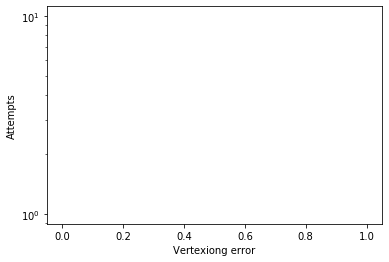

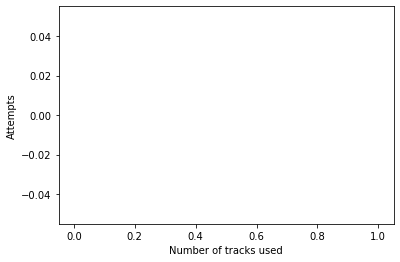

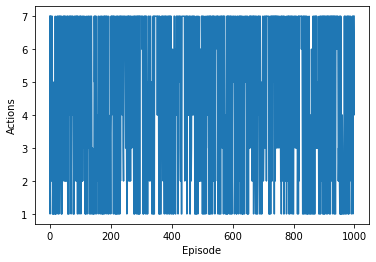

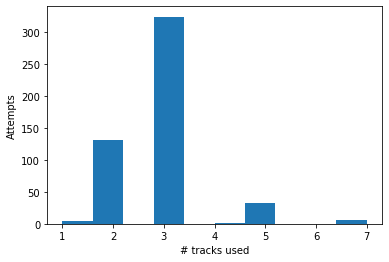

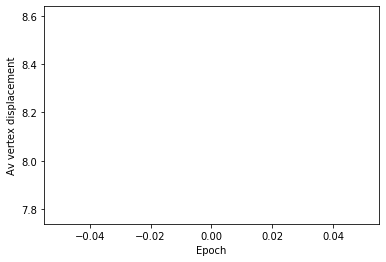

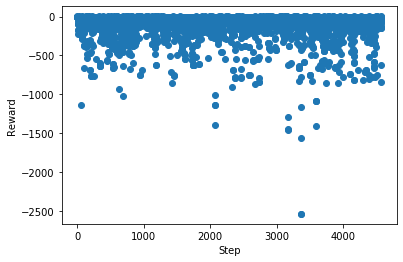

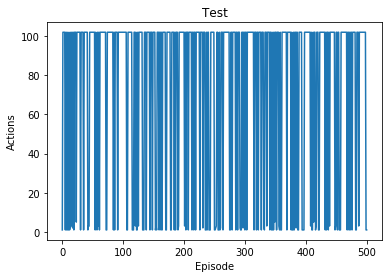

1001
4571


In [18]:
plt.plot(range(len(episode_lengths)),episode_lengths)
plt.xlabel("Episode")
plt.ylabel("Actions")
plt.savefig(f"{directory}RL_epilength.png")
plt.show()

plt.scatter(range(len(rewards)), rewards)
plt.xlabel("Step")
plt.ylabel("Reward")
plt.savefig(f"{directory}RL_rewards.png")
plt.show()


print(len(memory))